In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from factor_analyzer import calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# Criptomonedas

## Cargado de datos

In [59]:
df = pd.read_csv('dataset/kline.csv', sep=';')
df.shape

(630691, 15)

## Compresión de los datos

In [60]:
df.head()

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume  ignore ticker        open_datetime  \
0            92429.917586       0    XRP  2020-01-01 00:00:00   
1           280854.952488       0    XRP  2020-01-01 01:00:00   
2           301337.420868       0    XRP  2020-01-01 02:00:00   
3            93134.098773       0    XRP  2020-01-01 03:00:00   
4           149272.489365       0    XRP  2020-01-01 04:00:00   

            close_datetime  
0  2020-01-01 00:59:59.999  
1  2020-01-01 01:59:59.999  
2  2020-01-01 02:59:59.999  
3  2020-01-01 03:59:59.999  
4  2020-01-01 04:59:59.999

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630691 entries, 0 to 630690
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open_time               630691 non-null  int64  
 1   open                    630691 non-null  float64
 2   high                    630691 non-null  float64
 3   low                     630691 non-null  float64
 4   close                   630691 non-null  float64
 5   volume                  630691 non-null  float64
 6   close_time              630691 non-null  int64  
 7   quote_volume            630691 non-null  float64
 8   count                   630691 non-null  int64  
 9   taker_buy_volume        630691 non-null  float64
 10  taker_buy_quote_volume  630691 non-null  float64
 11  ignore                  630691 non-null  int64  
 12  ticker                  630691 non-null  object 
 13  open_datetime           630691 non-null  object 
 14  close_datetime      

Eliminamos datos de la api como ignore y corregimos el tipo de datos de open_datime y close_datetime a datetime.

In [62]:
df = df.drop(['ignore'], axis=1)
df['open_datetime'] = pd.to_datetime(df['open_datetime'])
df['close_datetime'] = pd.to_datetime(df['close_datetime'])

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630691 entries, 0 to 630690
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   open_time               630691 non-null  int64         
 1   open                    630691 non-null  float64       
 2   high                    630691 non-null  float64       
 3   low                     630691 non-null  float64       
 4   close                   630691 non-null  float64       
 5   volume                  630691 non-null  float64       
 6   close_time              630691 non-null  int64         
 7   quote_volume            630691 non-null  float64       
 8   count                   630691 non-null  int64         
 9   taker_buy_volume        630691 non-null  float64       
 10  taker_buy_quote_volume  630691 non-null  float64       
 11  ticker                  630691 non-null  object        
 12  open_datetime           630691

Definimos las variable numericas para analizar.

In [64]:
numcols = [
    'open',
    'high',
    'low',
    'close',
    'volume', 
    'quote_volume',            
    'count',                   
    'taker_buy_volume',        
    'taker_buy_quote_volume'
]

Obseramos que tenemos los datos de 20 criptmonoedas incluyendo Bitcoin y Ethereum.

In [65]:
df['ticker'].unique()

array(['XRP', 'ETH', 'DOT', 'SHIB', 'BTC', 'XLM', 'LINK', 'AVAX', 'SOL',
       'MATIC', 'FET', 'GRT', 'LTC', 'UNI', 'DOGE', 'NEAR', 'CHZ', 'ADA',
       'BCH', 'APE'], dtype=object)

Los datos tienen una alta dispersión por lo cual sería complicado realizar un análisis por variable además observamos que las fechas mínima y máxima en open_datime son 2020-01-01 00:00:00 y 2023-12-31 23:00:00.

In [66]:
df.describe()

open_time           open           high            low  \
count  6.306910e+05  630691.000000  630691.000000  630691.000000   
mean   1.645779e+12    1726.995843    1735.626871    1717.892228   
min    1.577837e+12       0.000006       0.000006       0.000005   
25%    1.617192e+12       0.210900       0.212800       0.208800   
50%    1.647288e+12       2.456000       2.483900       2.426600   
75%    1.675681e+12      40.786500      41.200000      40.392900   
max    1.704064e+12   68635.120000   69000.000000   68451.190000   
std    3.485624e+10    7494.181302    7532.344237    7453.900338   

               close        volume    close_time  quote_volume         count  \
count  630691.000000  6.306910e+05  6.306910e+05  6.306910e+05  6.306910e+05   
mean     1727.055151  1.661757e+10  1.645782e+12  1.272568e+07  1.448525e+04   
min         0.000006  0.000000e+00  1.577840e+12  0.000000e+00  0.000000e+00   
25%         0.210925  5.178149e+04  1.617196e+12  4.922499e+05  1.551000e+03   
50%         2.456400  4.994828e+05  1.647292e+12  1.765802e+06  4.183000e+03   
75%        40.789500  5.067622e+06  1.675685e+12  6.956950e+06  1.211800e+04   
max     68633.690000  3.206736e+13  1.704067e+12  3.005634e+09  2.319867e+06   
std      7494.352075  2.160753e+11  3.485624e+10  4.250578e+07  3.853990e+04   

       taker_buy_volume  taker_buy_quote_volume  \
count      6.306910e+05            6.306910e+05   
mean       8.307684e+09            6.314952e+06   
min        0.000000e+00            0.000000e+00   
25%        2.507993e+04            2.381368e+05   
50%        2.390943e+05            8.682346e+05   
75%        2.485129e+06            3.450911e+06   
max        1.672931e+13            1.502977e+09   
std        1.093683e+11            2.116403e+07   

                       open_datetime                 close_datetime  
count                         630691                         630691  
mean   2022-02-25 08:47:00.477856768  2022-02-25 09:47:00.108677888  
min              2020-01-01 00:00:00     2020-01-01 00:59:59.999000  
25%              2021-03-31 12:00:00  2021-03-31 12:59:59.999000064  
50%              2022-03-14 20:00:00  2022-03-14 20:59:59.999000064  
75%              2023-02-06 11:00:00  2023-02-06 11:59:59.999000064  
max              2023-12-31 23:00:00     2023-12-31 23:59:59.999000  
std                              NaN                            NaN

### Test de distribución normal

In [67]:
from itertools import combinations

def evalute_normal_dist(df):
    results = []
    for col in df.columns:
        hip = ss.shapiro(df[col])
        results.append((col, hip))
    for result in results:
        print(result[0])
        if result[1][1] > 0.05:
            print("  Tiene distribución normal.")
        else:
            print("  NO tiene distribución normal.")

In [68]:
evalute_normal_dist(df[numcols])

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 630691.
  res = hypotest_fun_out(*samples, **kwds)


open
  NO tiene distribución normal.
high
  NO tiene distribución normal.
low
  NO tiene distribución normal.
close
  NO tiene distribución normal.
volume
  NO tiene distribución normal.
quote_volume
  NO tiene distribución normal.
count
  NO tiene distribución normal.
taker_buy_volume
  NO tiene distribución normal.
taker_buy_quote_volume
  NO tiene distribución normal.


### Evaluación de correlación

In [69]:
def evalute_corr(df, min_corr=0.9):
    results = []
    for col1, col2 in combinations(df.columns, 2):
        res = ss.spearmanr(df[col1], df[col2])
        results.append((col1, col2, res))
    print("Correlación")
    for result in sorted(results, reverse=True, key=lambda x: x[2][0]):
        if result[2][1] < 0.05 and abs(result[2][0]) > min_corr:
            print(f"{result[0]} | {result[1]}")
            print(f"  corr={round(result[2][0], 6)}")

Al tener solo columnas sin distribución normal la correlacion se medira utilizando la correlación de Spearman

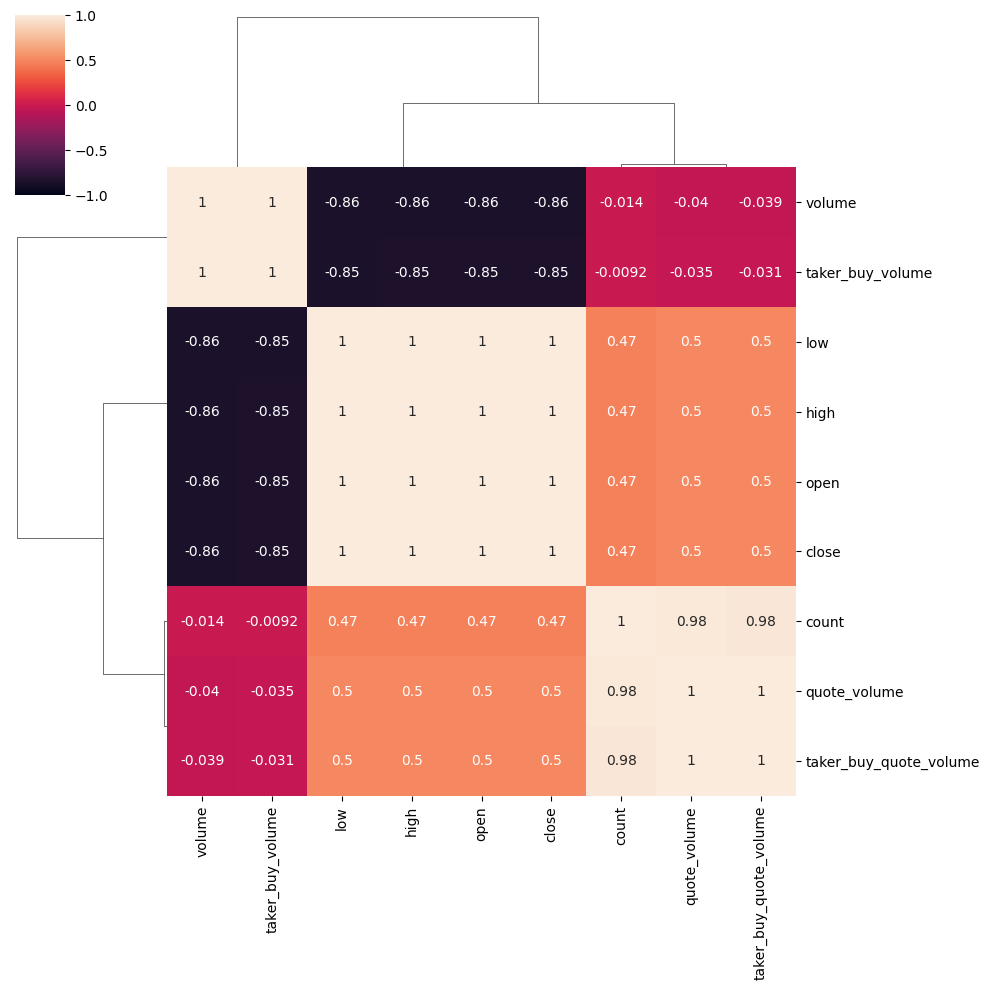

In [70]:
sns.clustermap(df[numcols].corr(method='spearman'), annot=True, vmin=-1, vmax=1)

In [71]:
evalute_corr(df[numcols], 0.9)

Correlación
high | close
  corr=0.999994
open | high
  corr=0.999991
low | close
  corr=0.99999
open | low
  corr=0.99999
open | close
  corr=0.99999
high | low
  corr=0.999981
volume | taker_buy_volume
  corr=0.998111
quote_volume | taker_buy_quote_volume
  corr=0.997263
quote_volume | count
  corr=0.978491
count | taker_buy_quote_volume
  corr=0.97585


## Preparación de los datos

### Limpieza de datos

Revisamos nuevamente que no existen datos faltantes

In [72]:
df.isna().sum()

open_time                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_volume              0
count                     0
taker_buy_volume          0
taker_buy_quote_volume    0
ticker                    0
open_datetime             0
close_datetime            0
dtype: int64

### Creación de variables

#### Variables derivadas como combinación

Definimos grupos de variables relacionadas con el precio, la moneda de cotización y el volumen.

In [73]:
price_cols = ['open', 'low', 'high', 'close']
quote_cols = ['count', 'quote_volume', 'taker_buy_quote_volume']
volume_cols = ['volume', 'taker_buy_volume']
df['id'] = df.index

##### Visualizaciones conociendo los variables agrupadas

In [74]:
def plot_by_id(cols, ylabel):
    plt.figure(figsize=(20, 6))
    for col in cols:
        sns.scatterplot(data=df, x='id', y=col, label=col, s=10)
    plt.xlabel('Row Index')
    plt.ylabel(ylabel)
    plt.title(f'Scatter Plot of {ylabel} by Row')
    plt.legend(loc="lower right")
    plt.show()

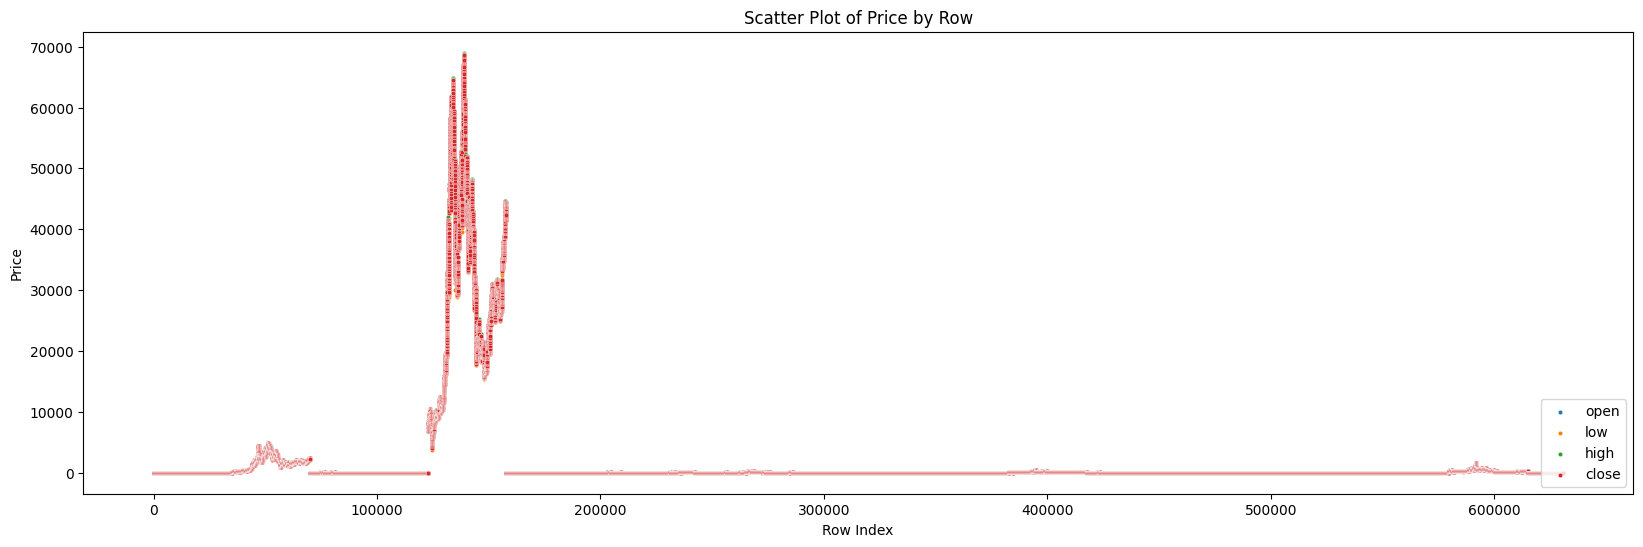

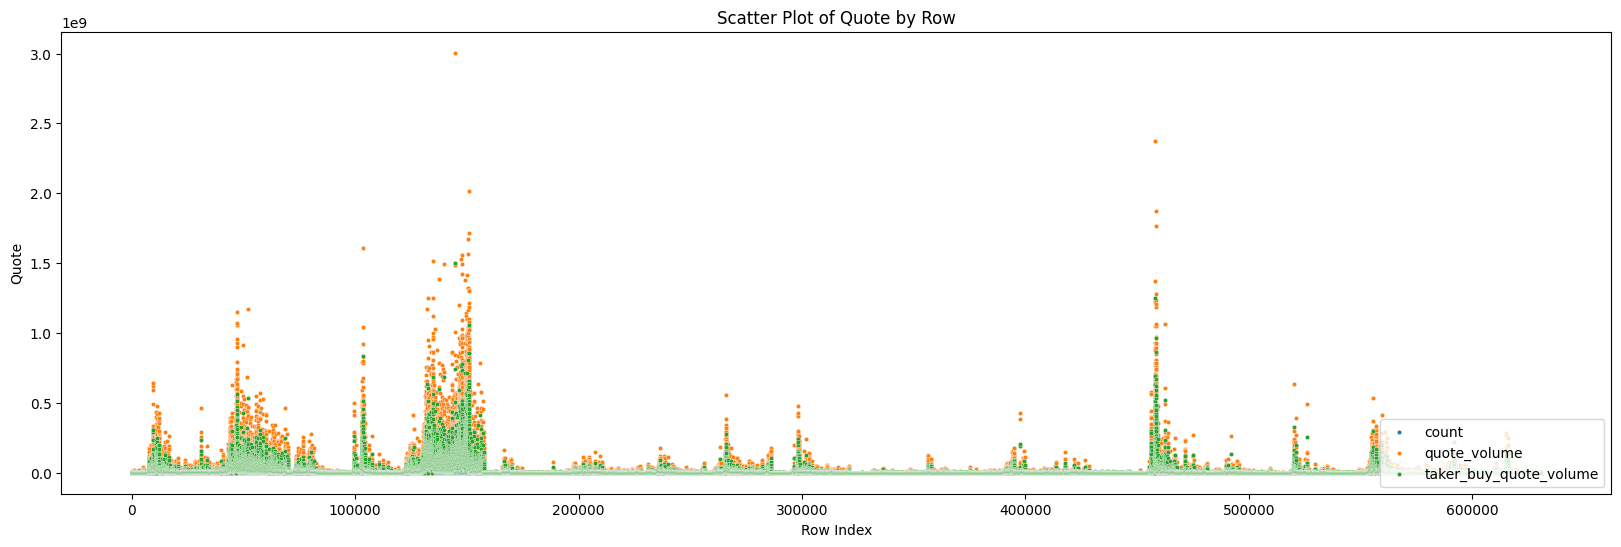

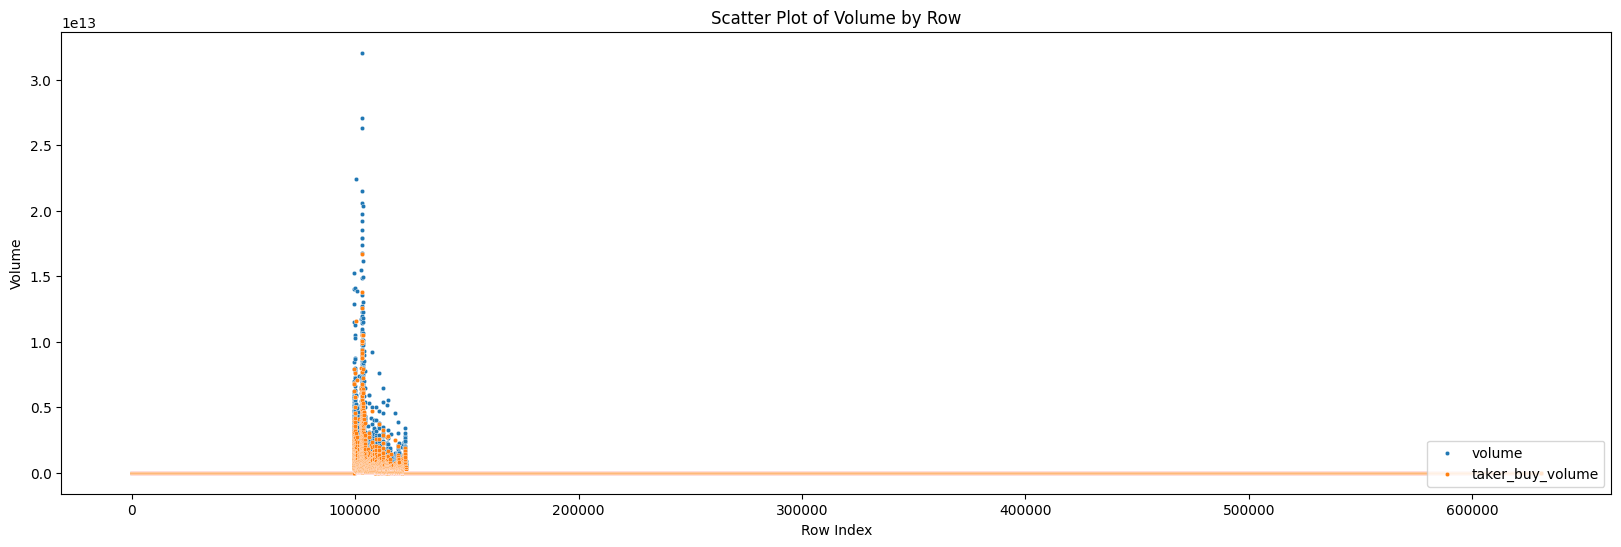

In [75]:
plot_by_id(price_cols, 'Price')
plot_by_id(quote_cols, 'Quote')
plot_by_id(volume_cols, 'Volume')
plt.show()

##### Mediana y media de precios

Luego, creamos una variable para precio como promedio y mediana del precio máximo, mínimo, de apertura y cierre.

In [76]:
df['mean_price'] = df[price_cols].sum(axis=1)/4
df['median_price'] = np.median(df[price_cols], axis=1)
df.head(5)

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  
0   0    0.192623      0.192665  
1   1    0.193057      0.193070  
2   2    0.193920      0.193945  
3   3    0.194035      0.194080  
4   4    0.193802      0.193800

#### Análisis de Componentes Principales (PCA)


In [77]:
import numpy as np
from factor_analyzer import calculate_bartlett_sphericity
def bartlett_sphericity(df):
    chi_square_value, p_value = calculate_bartlett_sphericity(df)
    print(f"value={chi_square_value}")
    print(f"np-value={p_value}")
    if p_value > 0.05:
        print("NO existe correlacion entre variables")
    else:
        print("Existe correlacion entre variables")

def pca_display(pca_model):    
    explained_variance = pca_model.explained_variance_
    explained_variance_ratio = pca_model.explained_variance_ratio_
    n = len(pca_model.components_)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Número de componentes principales')
    ax1.set_ylabel('Varianza explicada', color=color)
    ax1.bar(range(1, n + 1), 
            explained_variance, alpha=0.6, color=color, label='Varianza explicada')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(1, n + 1))

    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Ratio de varianza explicada acumulada', color=color)
    ax2.plot(range(1, n + 1), 
             np.cumsum(explained_variance_ratio), color=color, marker='o', linestyle='dashed', linewidth=2, markersize=5, label='Ratio acumulado')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)
    ax2.set_xticks(range(1, n + 1))
    
    plt.title('Varianza explicada por número de componentes principales')
    fig.tight_layout()

    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    plt.show()


def pca_auto_components(X):
    std_scaler = StandardScaler()
    X_std = std_scaler.fit_transform(X)
    pca_model = PCA(n_components=X.shape[1]).fit(X_std)
    print(X_std.shape)
    pca_display(pca_model)
    n_components = sum(pca_model.explained_variance_ >= 1)
    components = pca_model.transform(X_std)[:, : n_components]
    print("Ratio de varianza explicada: ", sum(pca_model.explained_variance_ratio_[: n_components]))
    return std_scaler, pca_model, components
    

PCA: precio
* Realizamos la prueba de esfericidad de barttlet para determinar si es óptimo aplicar PCA
* Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1.
* Conservamos únicamente un componente con una varianza explicada final de 0.9999818720925833.

PCA: moneda de cotización
* Realizamos la prueba de esfericidad de barttlet para determinar si es óptimo aplicar PCA
* Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1
* Conservamos únicamente un componente con una varianza explicada final de 0.9617053572727392

PCA: volumen
* Ejecutamos el análisis y selección de componentes principales automatizado para componentes con varianza mayor a 1
* Conservamos únicamente un componente con una varianza explicada final de 0.9617053572727392

------------------------------
Price
------------------------------
value=19903317.633998383
np-value=0.0
Existe correlacion entre variables
(630691, 4)


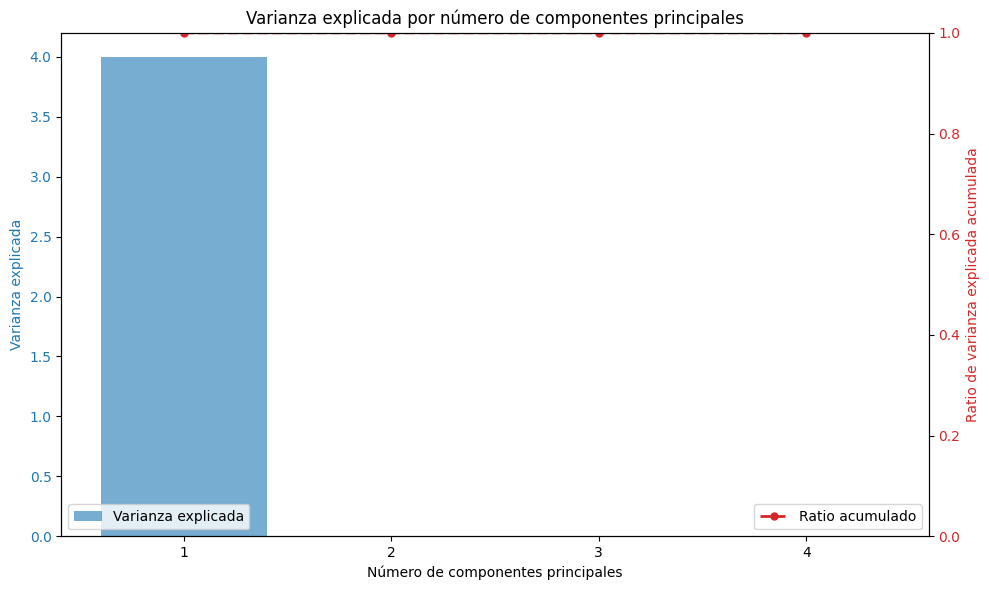

Ratio de varianza explicada:  0.9999818720925833
------------------------------
Quote
------------------------------
value=4528294.202298501
np-value=0.0
Existe correlacion entre variables
(630691, 3)


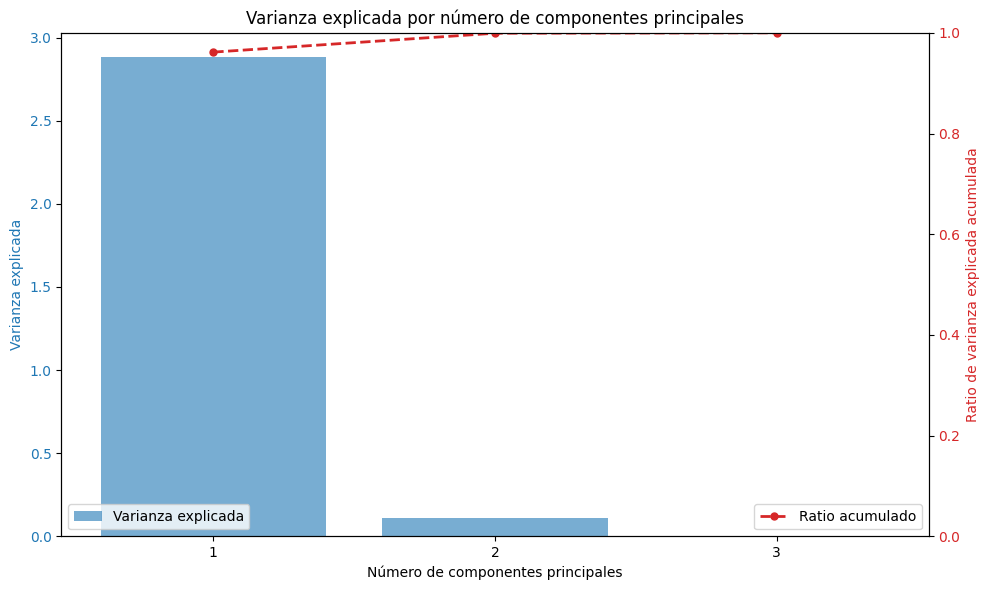

Ratio de varianza explicada:  0.9617053572727392
------------------------------
Volume
------------------------------
value=3385839.681587918
np-value=0.0
Existe correlacion entre variables
(630691, 2)


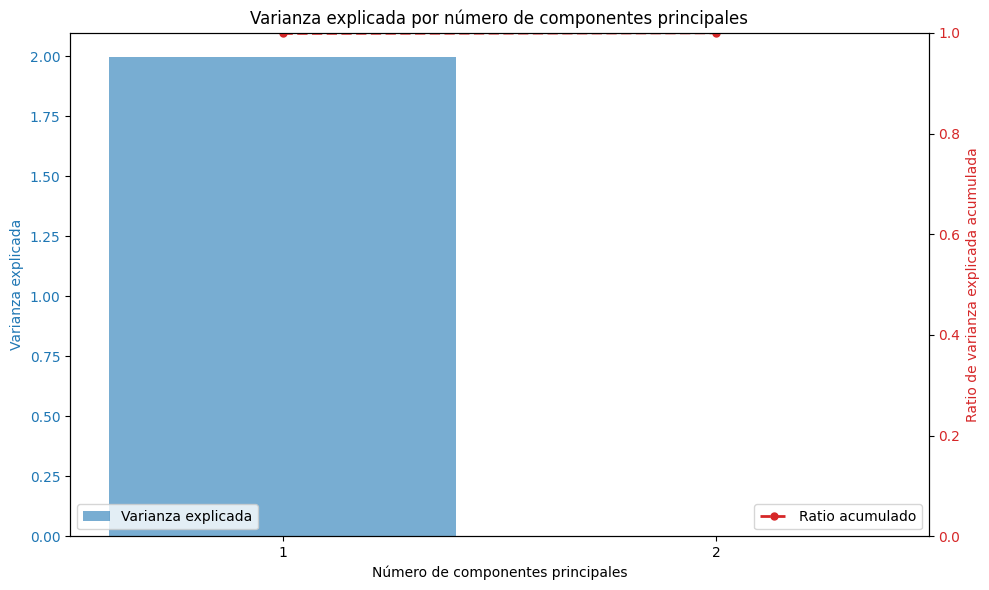

Ratio de varianza explicada:  0.9988333381591071


open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  pc_quote  pc_volume  
0   0    0.192623      0.192665 -0.460841 -0.536331  -0.108086  
1   1    0.193057      0.193070 -0.460841 -0.514222  -0.108076  
2   2    0.193920      0.193945 -0.460841 -0.524666  -0.108076  
3   3    0.194035      0.194080 -0.460841 -0.540374  -0.108087  
4   4    0.193802      0.193800 -0.460841 -0.538127  -0.108085

In [78]:
print("------------------------------")
print("Price")
print("------------------------------")
bartlett_sphericity(df[price_cols])
std_scaler, pca_model, components = pca_auto_components(df[price_cols])
joblib.dump(std_scaler, 'model/pca_std_scaler_price.pkl')
joblib.dump(pca_model, 'model/pca_model_price.pkl')
df['pc_price'] = components
print("------------------------------")
print("Quote")
print("------------------------------")
bartlett_sphericity(df[quote_cols])
std_scaler, pca_model, components = pca_auto_components(df[quote_cols])
joblib.dump(std_scaler, 'model/pca_std_scaler_quote.pkl')
joblib.dump(pca_model, 'model/pca_model_quote.pkl')
df['pc_quote'] = components
print("------------------------------")
print("Volume")
print("------------------------------")
bartlett_sphericity(df[volume_cols])
std_scaler, pca_model, components = pca_auto_components(df[volume_cols])
joblib.dump(std_scaler, 'model/pca_std_scaler_volume.pkl')
joblib.dump(pca_model, 'model/pca_model_volume.pkl')
df['pc_volume'] = components
df.head(5)

##### Análisis del procedimiento PCA

Definimos las columnas correspondientes a los componentes. Luego, verificamos que no tienen distribución normal al igual que sus variables de origen.

In [79]:
pc_cols = ['pc_price', 'pc_quote', 'pc_volume']
evalute_normal_dist(df[['pc_price', 'pc_quote', 'pc_volume']])

pc_price
  NO tiene distribución normal.
pc_quote
  NO tiene distribución normal.
pc_volume
  NO tiene distribución normal.


c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 630691.
  res = hypotest_fun_out(*samples, **kwds)


Podemos observar un comportamiento basico de mercado, precios altos reducen la volumen de ventas

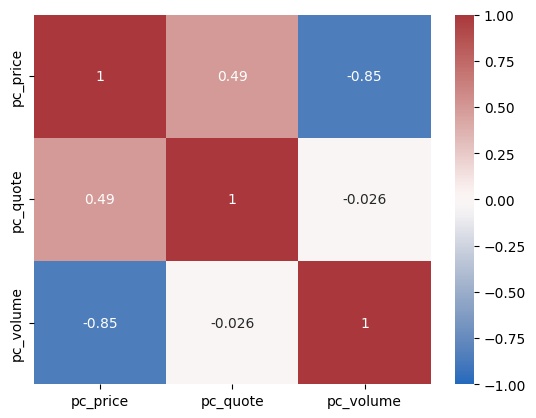

In [80]:
sns.heatmap(df[pc_cols].corr(method='spearman'), annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.show()

In [81]:
def timeline_per_ticker(df):
    tickers = df['ticker'].unique().tolist()
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(20, 6*len(tickers)))

    for i, ticker in enumerate(tickers):
        df_ticker = df[df['ticker'] == ticker]
        df_ticker.sort_values('open_datetime')
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['open'], 
            alpha=0.1, color='black', label='open', linewidth=0.5)
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['median_price'], 
            alpha=0.1, color='blue', label='median_price', linewidth=0.5)
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['mean_price'], 
            alpha=0.1, color='red', label='mean_price', linewidth=0.5)
        
        axes[i].set_title(f'Evolución de {ticker}')
        axes[i].set_xlabel('Tiempo')
        axes[i].set_ylabel('Valores')
        axes[i].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))  # Establecer la fecha de inicio y final del eje y
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

def timeserie_volume_per_ticker(df):
    tickers = df['ticker'].unique().tolist()
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(20, 6*len(tickers)))

    for i, ticker in enumerate(tickers):
        df_ticker = df[df['ticker'] == ticker]
        df_ticker.sort_values('open_datetime')
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['volume'], 
            alpha=0.1, color='black', label='volume', linewidth=0.5)
        axes[i].plot(
            df_ticker['open_datetime'], df_ticker['taker_buy_volume'], 
            alpha=0.1, color='blue', label='taker_buy_volume', linewidth=0.5)
        
        axes[i].set_title(f'Evolución de {ticker}')
        axes[i].set_xlabel('Tiempo')
        axes[i].set_ylabel('Valores')
        axes[i].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))  # Establecer la fecha de inicio y final del eje y
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

def axe_timeserie_plot(df_timeseries: pd.DataFrame):
    n = df_timeseries.shape[1]
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 4*n))
    for i, col in enumerate(df_timeseries.columns):
        axes[i].plot(
            df_timeseries.index, df_timeseries[col], 
            color='blue', label='Target', linewidth=0.5)
        axes[i].set_xlim(df_timeseries.index[0], df_timeseries.index[-1])  # Establecer la fecha de inicio y final del eje y
        axes[i].set_title(col)
        axes[i].grid(True)
    plt.show()

def timeserie_plot(timeserie: pd.Series):
    plt.figure(figsize=(10,  5))

    plt.plot(
        timeserie.index, timeserie, 
        color='blue', label='Target', linewidth=0.5
        )
    plt.xlabel('Tiempo')
    plt.ylabel('Valores')
    plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2023-12-31'))  # Establecer la fecha de inicio y final del eje y
    plt.legend()
    plt.grid(True)
    plt.show()

def timeserie_preprocessing(df, ticker, time_col, target_col, mean_window=24):
    df_target = df.loc[df['ticker'] == ticker, [time_col, target_col]]
    df_target.columns = ['timestamp', 'target']
    df_target.sort_values('timestamp')
    df_target = df_target.set_index('timestamp')
    df_target = df_target.asfreq('h')

    if df_target.isna().sum()['target'] > 0:
        df_target['target_mean'] = df_target['target'].rolling(window=mean_window, min_periods=1).mean()
        df_target['target'] = df_target['target'].combine_first(df_target['target_mean'])
        df_target = df_target.drop('target_mean', axis=1)
        
    print(ticker, "missing values", df_target.isna().sum())
    return df_target

def timeserie_ticker_processing(df: pd.DataFrame, ticker, index_col, value_col, mean_window=24):
    timeserie = df.loc[df['ticker'] == ticker, [index_col, value_col]]
    timeserie.columns  = ['timestamp', ticker]
    
    timeserie = timeserie.set_index('timestamp')
    timeserie = timeserie.asfreq('h')
    n_missings = timeserie.isna().sum()
    if n_missings[ticker] > 0:
        mean_serie = timeserie[ticker].rolling(window=mean_window, min_periods=1).mean()
        timeserie[ticker] = timeserie[ticker].combine_first(mean_serie)
    timeserie.columns = [ticker]
    print(ticker, "missing values", timeserie.isna().sum().iloc[0])
    return timeserie

def df_timeseries_processing(df: pd.DataFrame, index_col, value_col, mean_window=24):
    return pd.concat([timeserie_ticker_processing(df, ticker, index_col, value_col, mean_window) for ticker in df['ticker'].unique()],axis=1) 

def missing_by_col(df):
    return df.isna().sum()/df.shape[0]*100

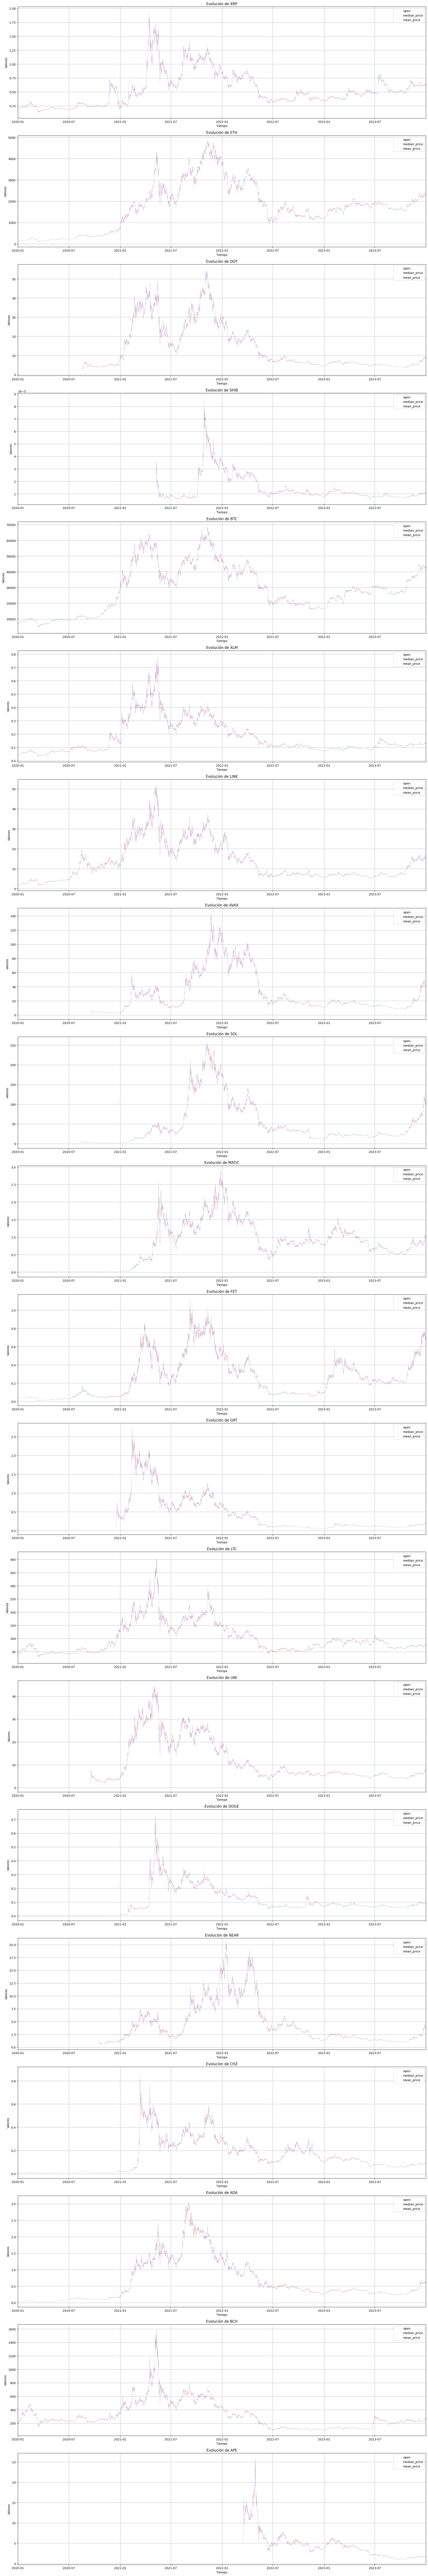

In [82]:
timeline_per_ticker(df)

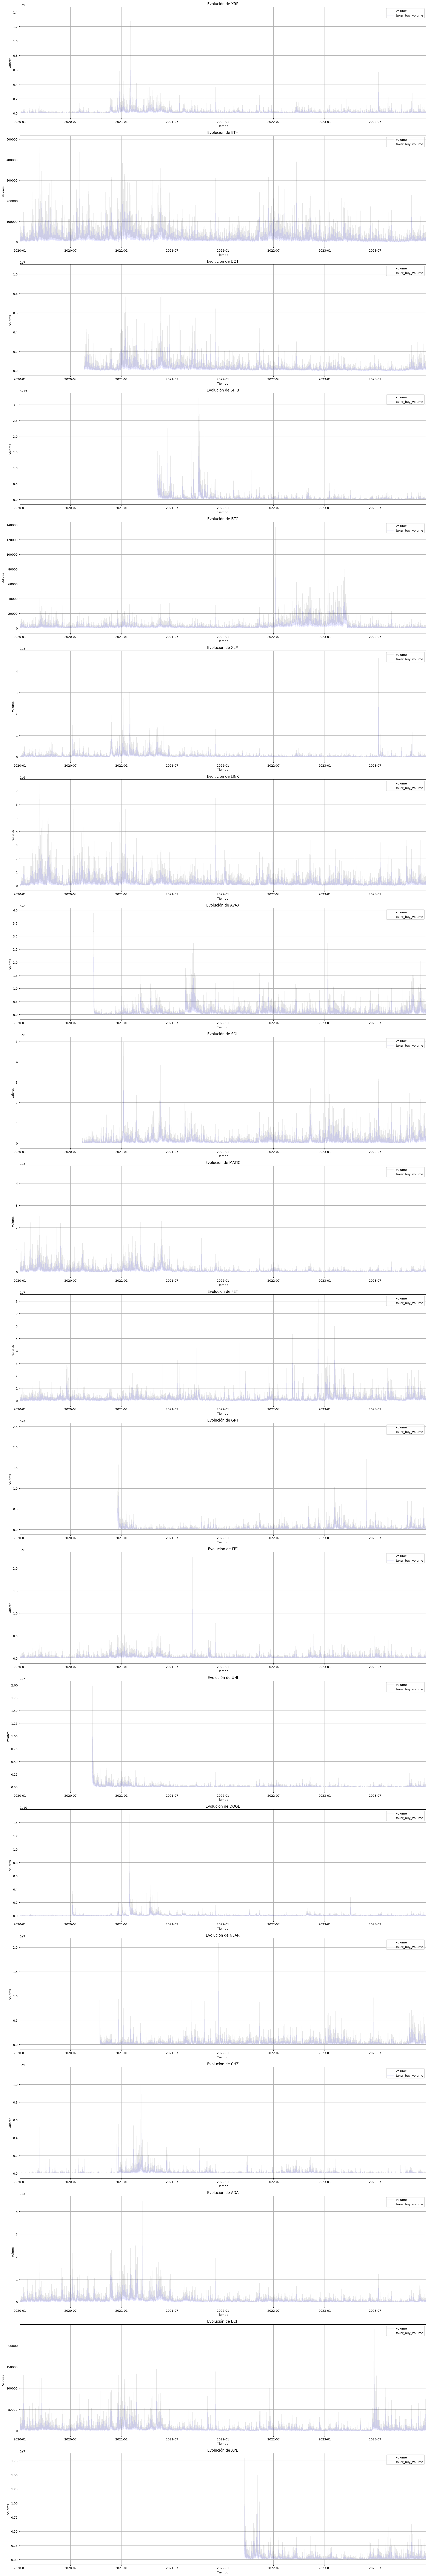

In [83]:
timeserie_volume_per_ticker(df)

In [84]:
df_timeserie_price = df_timeseries_processing(df, "open_datetime", 'mean_price')
#df_timeserie_price = df_timeserie_price.apply(lambda x: x.rolling(window=6).mean()).dropna()
df_timeserie_price.head()

XRP missing values 0
ETH missing values 0
DOT missing values 0
SHIB missing values 0
BTC missing values 0
XLM missing values 0
LINK missing values 0
AVAX missing values 0
SOL missing values 0
MATIC missing values 0
FET missing values 0
GRT missing values 0
LTC missing values 0
UNI missing values 0
DOGE missing values 0
NEAR missing values 0
CHZ missing values 0
ADA missing values 0
BCH missing values 0
APE missing values 0


XRP       ETH  DOT  SHIB        BTC       XLM  \
timestamp                                                                 
2020-01-01 00:00:00  0.192623  128.9750  NaN   NaN  7185.9925  0.044900   
2020-01-01 01:00:00  0.193057  129.7350  NaN   NaN  7199.6125  0.045037   
2020-01-01 02:00:00  0.193920  130.7025  NaN   NaN  7228.6625  0.045198   
2020-01-01 03:00:00  0.194035  130.4700  NaN   NaN  7233.1675  0.045210   
2020-01-01 04:00:00  0.193802  130.3250  NaN   NaN  7221.8250  0.045140   

                         LINK  AVAX  SOL     MATIC       FET  GRT      LTC  \
timestamp                                                                    
2020-01-01 00:00:00  1.766050   NaN  NaN  0.013805  0.037205  NaN  41.2550   
2020-01-01 01:00:00  1.774125   NaN  NaN  0.013862  0.037542  NaN  41.4675   
2020-01-01 02:00:00  1.792875   NaN  NaN  0.013962  0.037905  NaN  41.7450   
2020-01-01 03:00:00  1.797475   NaN  NaN  0.013917  0.037927  NaN  41.6775   
2020-01-01 04:00:00  1.795425   NaN  NaN  0.013915  0.037923  NaN  41.6050   

                     UNI      DOGE  NEAR       CHZ       ADA       BCH  APE  
timestamp                                                                    
2020-01-01 00:00:00  NaN  0.002013   NaN  0.007045  0.032795  204.2925  NaN  
2020-01-01 01:00:00  NaN  0.002017   NaN  0.007091  0.032888  205.5275  NaN  
2020-01-01 02:00:00  NaN  0.002027   NaN  0.007117  0.033085  206.9175  NaN  
2020-01-01 03:00:00  NaN  0.002018   NaN  0.007141  0.033095  206.4550  NaN  
2020-01-01 04:00:00  NaN  0.002015   NaN  0.007174  0.032987  206.0450  NaN

In [85]:
df_timeserie_volume = df_timeseries_processing(df, "open_datetime", 'volume')
#df_timeserie_volume = df_timeserie_volume.apply(lambda x: x.rolling(window=6).mean()).dropna()
df_timeserie_volume.head()

XRP missing values 0
ETH missing values 0
DOT missing values 0
SHIB missing values 0
BTC missing values 0
XLM missing values 0
LINK missing values 0
AVAX missing values 0
SOL missing values 0
MATIC missing values 0
FET missing values 0
GRT missing values 0
LTC missing values 0
UNI missing values 0
DOGE missing values 0
NEAR missing values 0
CHZ missing values 0
ADA missing values 0
BCH missing values 0
APE missing values 0


XRP          ETH  DOT  SHIB         BTC       XLM  \
timestamp                                                                      
2020-01-01 00:00:00  1339147.7   7769.17336  NaN   NaN  511.814901  210820.1   
2020-01-01 01:00:00  2339976.0  11344.65516  NaN   NaN  883.052603  824308.3   
2020-01-01 02:00:00  2275718.8   7603.35623  NaN   NaN  655.156809  373344.2   
2020-01-01 03:00:00   972145.7   4968.55433  NaN   NaN  783.724867  200236.6   
2020-01-01 04:00:00  1176061.9   3397.90747  NaN   NaN  467.812578  160708.3   

                         LINK  AVAX  SOL      MATIC        FET  GRT  \
timestamp                                                             
2020-01-01 00:00:00  13744.99   NaN  NaN  2250179.1   234017.8  NaN   
2020-01-01 01:00:00  28751.66   NaN  NaN  6088706.4  1358578.0  NaN   
2020-01-01 02:00:00  16018.83   NaN  NaN  8102845.3  1023925.9  NaN   
2020-01-01 03:00:00  16472.10   NaN  NaN  3004188.0  1705979.3  NaN   
2020-01-01 04:00:00  30347.28   NaN  NaN  1598647.0   345410.0  NaN   

                            LTC  UNI       DOGE  NEAR       CHZ        ADA  \
timestamp                                                                    
2020-01-01 00:00:00  2828.06038  NaN   963091.0   NaN  116006.0  1166000.9   
2020-01-01 01:00:00  6814.68608  NaN  1075963.0   NaN  125325.0  1560751.8   
2020-01-01 02:00:00  5757.19484  NaN  5947395.0   NaN  254493.0  1091975.1   
2020-01-01 03:00:00  3873.02370  NaN  1963268.0   NaN  417710.0   739364.9   
2020-01-01 04:00:00  5317.81964  NaN  1077698.0   NaN  142895.0  1350480.0   

                            BCH  APE  
timestamp                             
2020-01-01 00:00:00   873.34784  NaN  
2020-01-01 01:00:00  2985.16511  NaN  
2020-01-01 02:00:00  1069.88154  NaN  
2020-01-01 03:00:00  1925.31346  NaN  
2020-01-01 04:00:00  1535.31679  NaN

In [86]:
df_timeserie_price.to_csv('dataset/price_timeseries.csv', sep=';')
df_timeserie_volume.to_csv('dataset/volume_timeseries.csv', sep=';')

# Series temporales

## Exploración de los datos

In [87]:
df.head()

open_time     open     high      low    close     volume  \
0  1577836800000  0.19285  0.19297  0.19219  0.19248  1339147.7   
1  1577840400000  0.19243  0.19372  0.19237  0.19371  2339976.0   
2  1577844000000  0.19371  0.19454  0.19325  0.19418  2275718.8   
3  1577847600000  0.19419  0.19427  0.19371  0.19397   972145.7   
4  1577851200000  0.19397  0.19410  0.19351  0.19363  1176061.9   

      close_time   quote_volume  count  taker_buy_volume  \
0  1577840399999  257925.439502   1278          479957.5   
1  1577843999999  452060.925165   2249         1453722.0   
2  1577847599999  441494.831939   1509         1552864.6   
3  1577851199999  188606.109345   1066          480068.8   
4  1577854799999  227937.280398   1077          770127.9   

   taker_buy_quote_volume ticker       open_datetime          close_datetime  \
0            92429.917586    XRP 2020-01-01 00:00:00 2020-01-01 00:59:59.999   
1           280854.952488    XRP 2020-01-01 01:00:00 2020-01-01 01:59:59.999   
2           301337.420868    XRP 2020-01-01 02:00:00 2020-01-01 02:59:59.999   
3            93134.098773    XRP 2020-01-01 03:00:00 2020-01-01 03:59:59.999   
4           149272.489365    XRP 2020-01-01 04:00:00 2020-01-01 04:59:59.999   

   id  mean_price  median_price  pc_price  pc_quote  pc_volume  
0   0    0.192623      0.192665 -0.460841 -0.536331  -0.108086  
1   1    0.193057      0.193070 -0.460841 -0.514222  -0.108076  
2   2    0.193920      0.193945 -0.460841 -0.524666  -0.108076  
3   3    0.194035      0.194080 -0.460841 -0.540374  -0.108087  
4   4    0.193802      0.193800 -0.460841 -0.538127  -0.108085

#### Construcción de series de tiempo de precio por cryptomoneda

Usamos las series de tiempo para formar un nuevo dataframe con las series de tiempo como columnas para que sean comparables

Para las series de tiempo utilizaremos como referencia la fecha de apertura del intervalo y el componente de precio

A causa de la transformación tenemos nuevos datos faltantes los cuales trataremos más adelante. Tienes que deshacerte de las criptomonedas con más del 15% de datos faltantes

In [88]:
print("--------------------")
print("Price")
print("--------------------")
missings = missing_by_col(df_timeserie_price)
print(missings) 
print("--------------------")
print("Volume")
print("--------------------")
missings = missing_by_col(df_timeserie_volume)
print(missings) 

--------------------
Price
--------------------
XRP       0.000000
ETH       0.000000
DOT      15.808236
SHIB     33.912275
BTC       0.000000
XLM       0.000000
LINK      0.000000
AVAX     18.155373
SOL      15.280630
MATIC     0.000000
FET       0.000000
GRT      24.081679
LTC       0.000000
UNI      17.804586
DOGE      0.000000
NEAR     19.658339
CHZ       0.000000
ADA       0.000000
BCH       0.000000
APE      55.207620
dtype: float64
--------------------
Volume
--------------------
XRP       0.000000
ETH       0.000000
DOT      15.808236
SHIB     33.912275
BTC       0.000000
XLM       0.000000
LINK      0.000000
AVAX     18.155373
SOL      15.280630
MATIC     0.000000
FET       0.000000
GRT      24.081679
LTC       0.000000
UNI      17.804586
DOGE      0.000000
NEAR     19.658339
CHZ       0.000000
ADA       0.000000
BCH       0.000000
APE      55.207620
dtype: float64


In [89]:
df_timeserie_price = df_timeserie_price[df_timeserie_price.columns[missings < 15]]
df_timeserie_volume = df_timeserie_volume[df_timeserie_volume.columns[missings < 15]]
print("--------------------")
print("Volume")
print("--------------------")
print(missing_by_col(df_timeserie_price))
print("--------------------")
print("Volume")
print("--------------------")
print(missing_by_col(df_timeserie_volume))

--------------------
Volume
--------------------
XRP      0.0
ETH      0.0
BTC      0.0
XLM      0.0
LINK     0.0
MATIC    0.0
FET      0.0
LTC      0.0
DOGE     0.0
CHZ      0.0
ADA      0.0
BCH      0.0
dtype: float64
--------------------
Volume
--------------------
XRP      0.0
ETH      0.0
BTC      0.0
XLM      0.0
LINK     0.0
MATIC    0.0
FET      0.0
LTC      0.0
DOGE     0.0
CHZ      0.0
ADA      0.0
BCH      0.0
dtype: float64


#### Test de distribución normal

Las series de tiempo del precio al igual que la de volumen siguen sin tener una distribución normal

In [90]:
print("-------------------------------")
print("PRICE")
print("-------------------------------")
evalute_normal_dist(df_timeserie_price)
print("-------------------------------")
print("VOLUME")
print("-------------------------------")
evalute_normal_dist(df_timeserie_volume)

-------------------------------
PRICE
-------------------------------
XRP
  NO tiene distribución normal.
ETH
  NO tiene distribución normal.
BTC
  NO tiene distribución normal.
XLM
  NO tiene distribución normal.
LINK
  NO tiene distribución normal.
MATIC
  NO tiene distribución normal.
FET
  NO tiene distribución normal.
LTC
  NO tiene distribución normal.
DOGE
  NO tiene distribución normal.
CHZ
  NO tiene distribución normal.
ADA
  NO tiene distribución normal.
BCH
  NO tiene distribución normal.
-------------------------------
VOLUME
-------------------------------
XRP
  NO tiene distribución normal.
ETH
  NO tiene distribución normal.
BTC
  NO tiene distribución normal.
XLM
  NO tiene distribución normal.
LINK
  NO tiene distribución normal.
MATIC
  NO tiene distribución normal.
FET
  NO tiene distribución normal.
LTC
  NO tiene distribución normal.
DOGE
  NO tiene distribución normal.
CHZ
  NO tiene distribución normal.
ADA
  NO tiene distribución normal.
BCH
  NO tiene distribu

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35064.
  res = hypotest_fun_out(*samples, **kwds)


#### Test de correlación

Utilizando un dendograma podemos verificar que existe un grado de correlacion entre las criptomonedas, por lo cual usaremos clusterización en un modelo especializado para series de tiempo utilizando muestras debido a la complejidad algoritmica

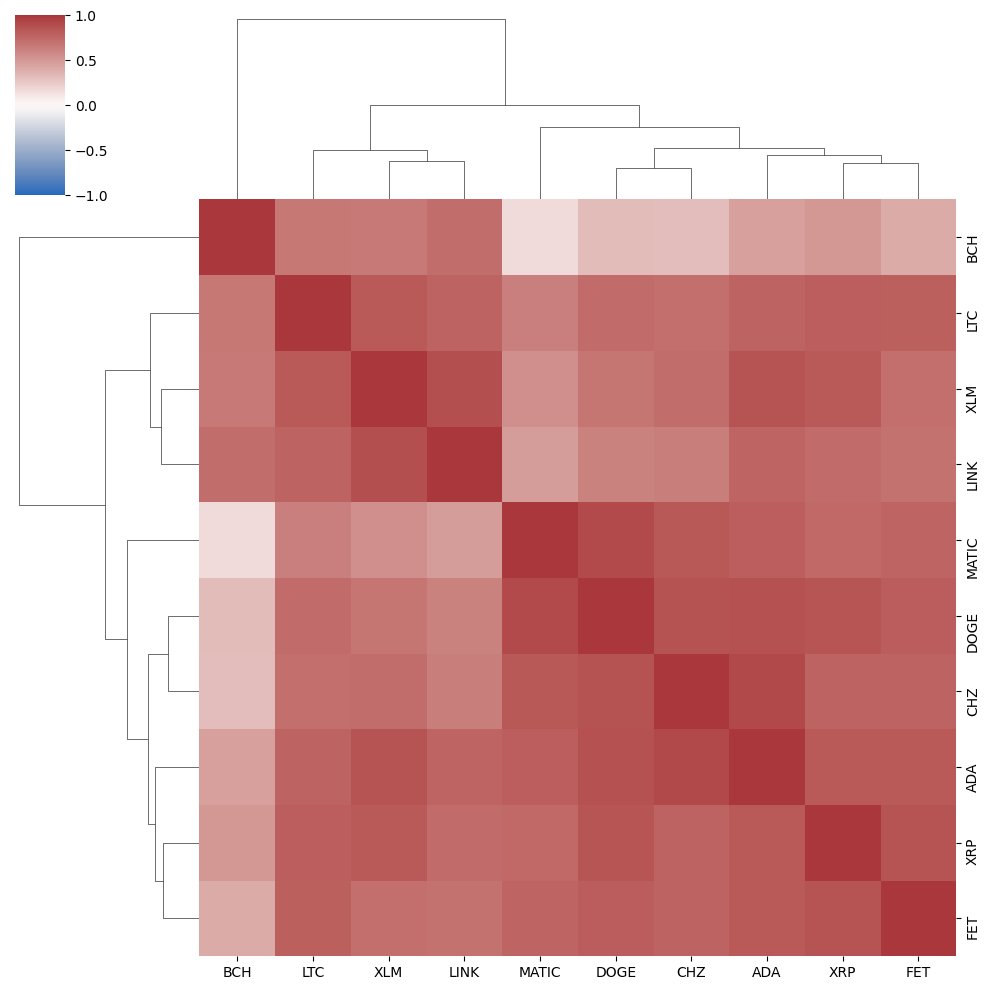

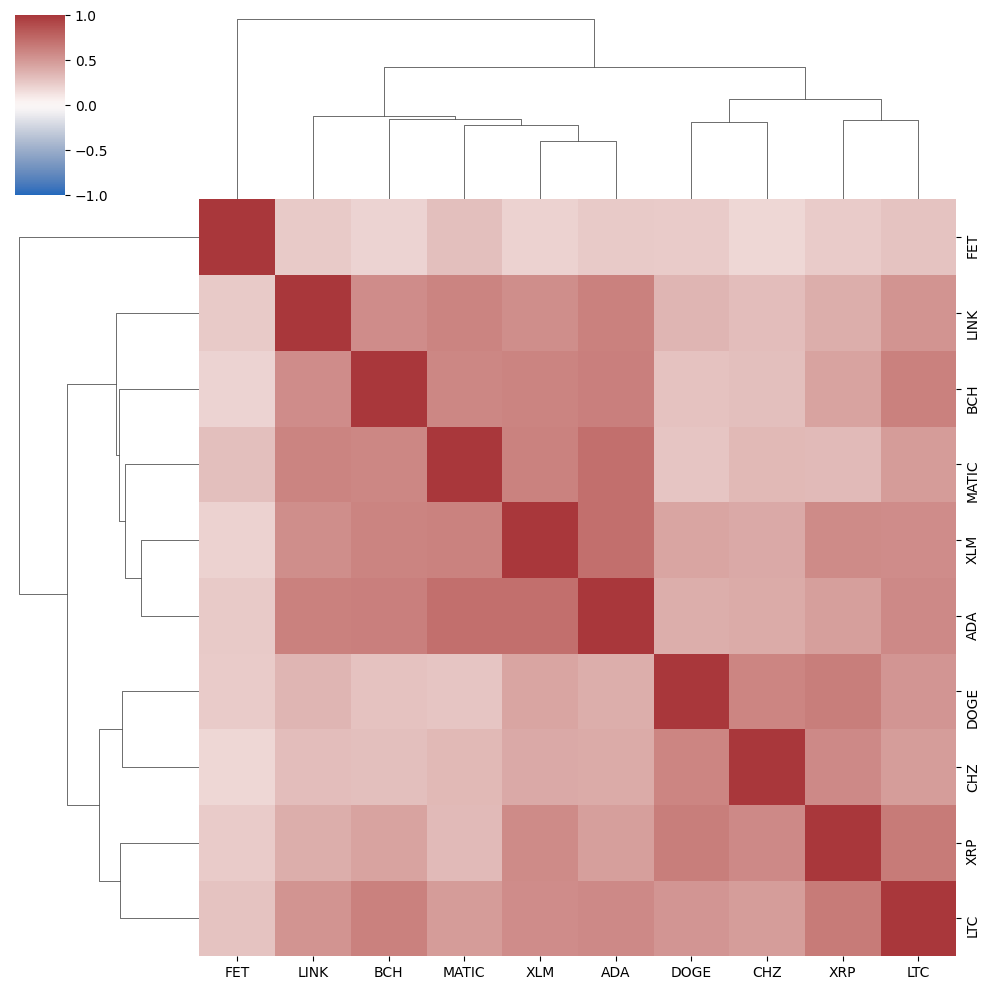

In [91]:
sns.clustermap(
    df_timeserie_price.drop(['BTC', 'ETH'], axis=1).corr(method='spearman'),
    cmap='vlag', 
    vmin=-1, vmax=1)
sns.clustermap(
    df_timeserie_volume.drop(['BTC', 'ETH'], axis=1).corr(method='spearman'),
    cmap='vlag', 
    vmin=-1, vmax=1)
plt.show()

In [92]:
print("-------------------------------")
print("PRICE")
print("-------------------------------")
evalute_corr(df_timeserie_price, 0.8)
print("-------------------------------")
print("VOLUME")
print("-------------------------------")
evalute_corr(df_timeserie_volume, 0.6)

-------------------------------
PRICE
-------------------------------
Correlación
XRP | ETH
  corr=0.924004
ETH | BTC
  corr=0.918715
CHZ | ADA
  corr=0.912136
ETH | FET
  corr=0.902884
ETH | DOGE
  corr=0.900975
MATIC | DOGE
  corr=0.899725
BTC | XLM
  corr=0.899106
BTC | FET
  corr=0.896063
ETH | ADA
  corr=0.892679
BTC | LTC
  corr=0.882191
XRP | BTC
  corr=0.88102
BTC | ADA
  corr=0.879054
XLM | LINK
  corr=0.87509
DOGE | ADA
  corr=0.872048
DOGE | CHZ
  corr=0.863223
XLM | ADA
  corr=0.857737
XRP | FET
  corr=0.851663
XRP | DOGE
  corr=0.848823
ETH | MATIC
  corr=0.848627
MATIC | CHZ
  corr=0.832307
XRP | ADA
  corr=0.82778
XRP | XLM
  corr=0.826084
ETH | CHZ
  corr=0.825347
XLM | LTC
  corr=0.824572
FET | ADA
  corr=0.823455
BTC | LINK
  corr=0.813452
FET | DOGE
  corr=0.805873
XRP | LTC
  corr=0.804293
MATIC | ADA
  corr=0.803696
-------------------------------
VOLUME
-------------------------------
Correlación
ETH | ADA
  corr=0.726244
MATIC | ADA
  corr=0.717132
XLM | ADA
  co

## Transformación de los datos

Suavizaremos los datos de volumen y precio para evitar el ruido generado por los intervalos cortos por hora

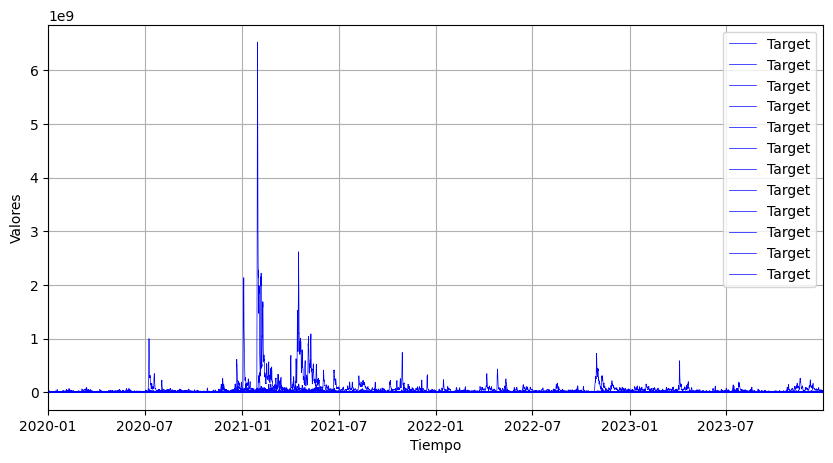

In [93]:
timeserie_plot(df_timeserie_volume.apply(lambda x: x.rolling(window=24).mean()).dropna())

In [94]:
df_timeserie_price = df_timeserie_price.apply(lambda x: x.rolling(window=24).mean()).dropna()
df_timeserie_volume = df_timeserie_volume.apply(lambda x: x.rolling(window=24).mean()).dropna()

#### Clusterización

In [95]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

def cluster_kshape(X, n_clusters):
    timeserie_scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    X_scaled = timeserie_scaler.fit_transform(X)
    ks_model = KShape(n_clusters=n_clusters, random_state=1234)
    clusters = ks_model.fit_predict(X_scaled)
    return timeserie_scaler, ks_model, clusters

def get_ticker_group_by_cluster(df_ticker, cluster_col):
    return [df_ticker[df_ticker[cluster_col] == cluster].index.tolist() 
            for cluster in df_ticker[cluster_col].unique()]

Utilizaremos el modelo de clusterización kshape que se especializa en series de tiempo, para lo cual suavizaremos la serie de tiempo usando una media moviel de 12 elementos. Además, tomaremos muestras para evitar un sobrecarga en el procesamiento. 

De esta forma, obtenemos 3 clusteres de criptomoneda por precio.

In [96]:
sample_df = df_timeserie_price.apply(lambda x: x.rolling(window=12).mean()).dropna()
sample_df = sample_df.iloc[::24].drop(['BTC', 'ETH'], axis=1)
X = sample_df.transpose()
timeserie_scaler, ks_model, clusters = cluster_kshape(X, 3)
joblib.dump(timeserie_scaler, 'model/price_timeserie_scaler.pkl')
joblib.dump(ks_model, 'model/kshape_model.pkl')

df_ticker = pd.DataFrame(clusters, columns=['price_cluster'], index=sample_df.columns.tolist())

sample_df = df_timeserie_volume.apply(lambda x: x.rolling(window=12).mean()).dropna()
sample_df = sample_df.iloc[::24].drop(['BTC', 'ETH'], axis=1)
X = sample_df.transpose()
timeserie_scaler, ks_model, clusters = cluster_kshape(X, 3)
joblib.dump(timeserie_scaler, 'model/volume_timeserie_scaler.pkl')
joblib.dump(ks_model, 'model/kshape_model.pkl')

df_ticker['volume_cluster'] = clusters

In [97]:
print(df_ticker.groupby('price_cluster').size())
print(df_ticker.groupby('volume_cluster').size())
df_ticker

price_cluster
0    2
1    4
2    4
dtype: int64
volume_cluster
0    3
1    3
2    4
dtype: int64


price_cluster  volume_cluster
XRP                1               2
XLM                2               2
LINK               2               0
MATIC              0               0
FET                0               1
LTC                2               2
DOGE               1               1
CHZ                1               1
ADA                1               0
BCH                2               2

#### Visualización de clusteres

In [98]:
price_cluster_tickers = get_ticker_group_by_cluster(df_ticker, 'price_cluster')
volume_cluster_tickers = get_ticker_group_by_cluster(df_ticker, 'volume_cluster')

Observamos que existe un grado de similitud entre las series de tiempo de precio de cada criptomoneda con las que se encuentran en su cluster

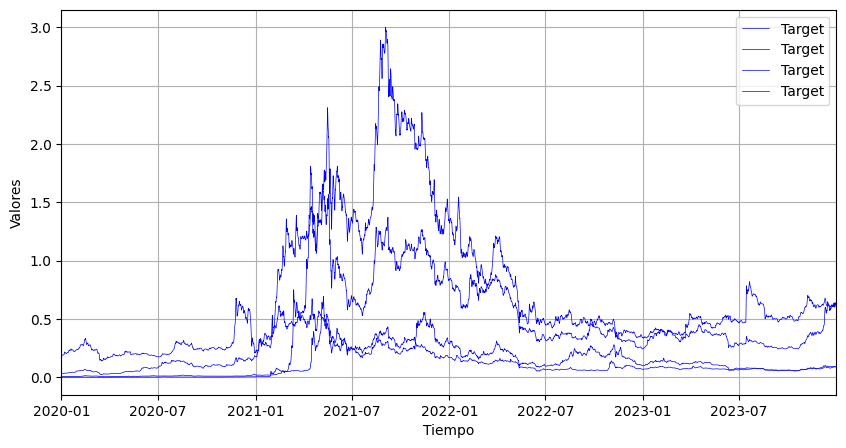

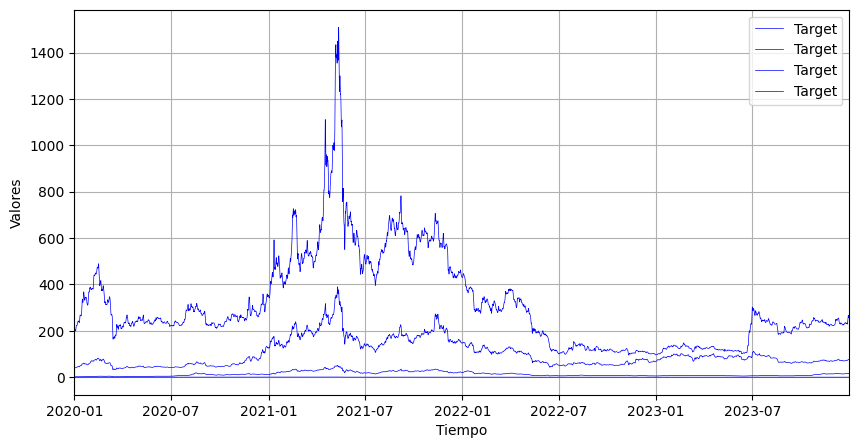

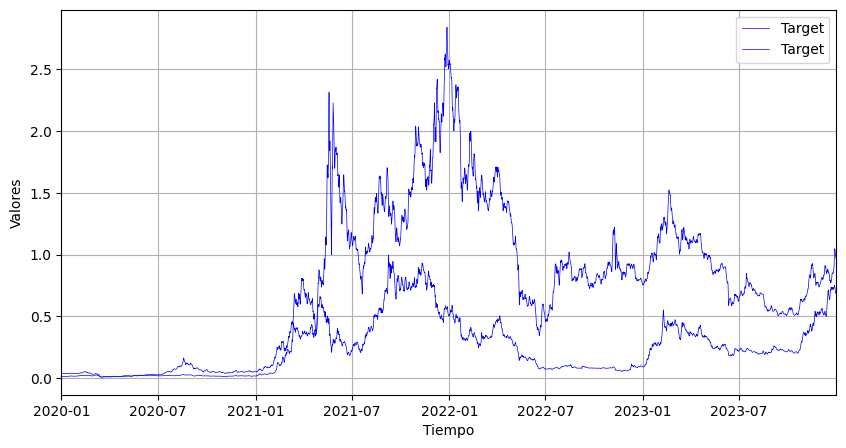

In [99]:
timeserie_plot(df_timeserie_price[price_cluster_tickers[0]])
timeserie_plot(df_timeserie_price[price_cluster_tickers[1]])
timeserie_plot(df_timeserie_price[price_cluster_tickers[2]])

Observamos que existe un grado de similitud entre las series de tiempo de precio de cada criptomoneda con las que se encuentran en su cluster aunque es menor que el visualizado en precios

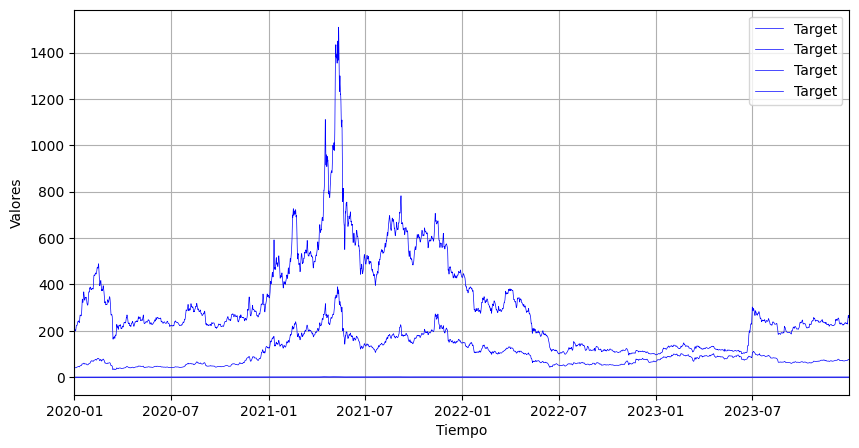

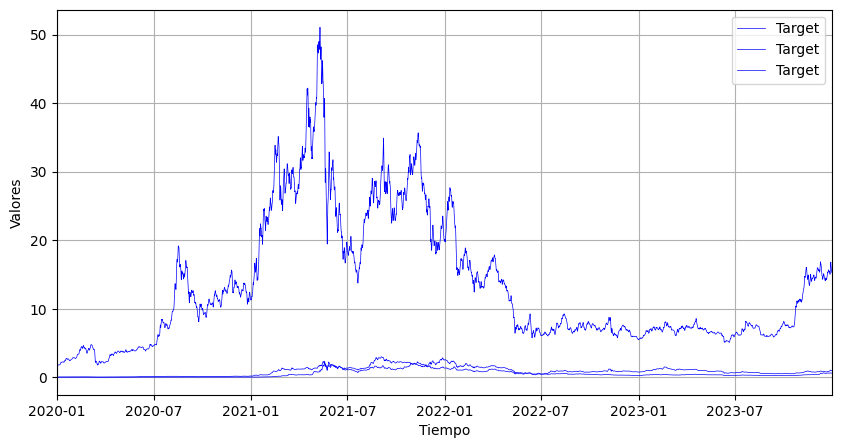

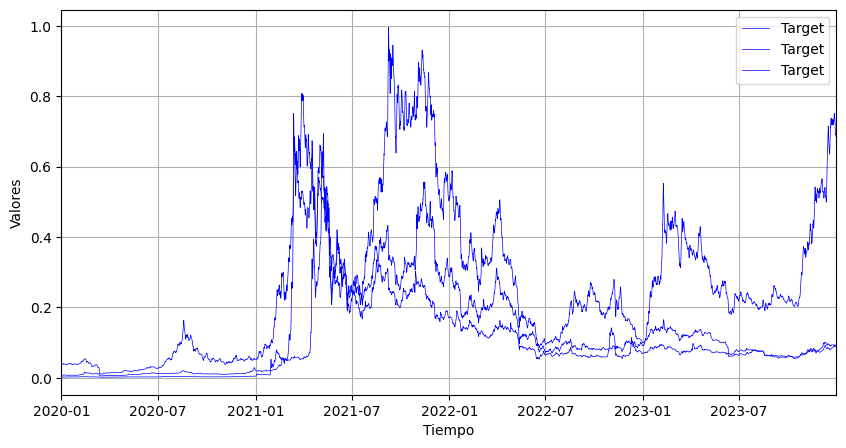

In [100]:
timeserie_plot(df_timeserie_price[volume_cluster_tickers[0]])
timeserie_plot(df_timeserie_price[volume_cluster_tickers[1]])
timeserie_plot(df_timeserie_price[volume_cluster_tickers[2]])

#### Creación de series de tiempo por clusteres

##### Creación de serie de tiempo de precio por cluster

Para el grupo 0 obtenemos un componente conservando la varianza del 87.06% de las variables de origen.

Para el grupo 1 obtenemos un componente conservando la varianza del 93.86% de las variables de origen.

Para el grupo 2 obtenemos un componente conservando la varianza del 83.19% de las variables de origen.

PRICE
-------------------------------
CLUSTER 0
-------------------------------
value=145922.20875670298
np-value=0.0
Existe correlacion entre variables
(35041, 4)


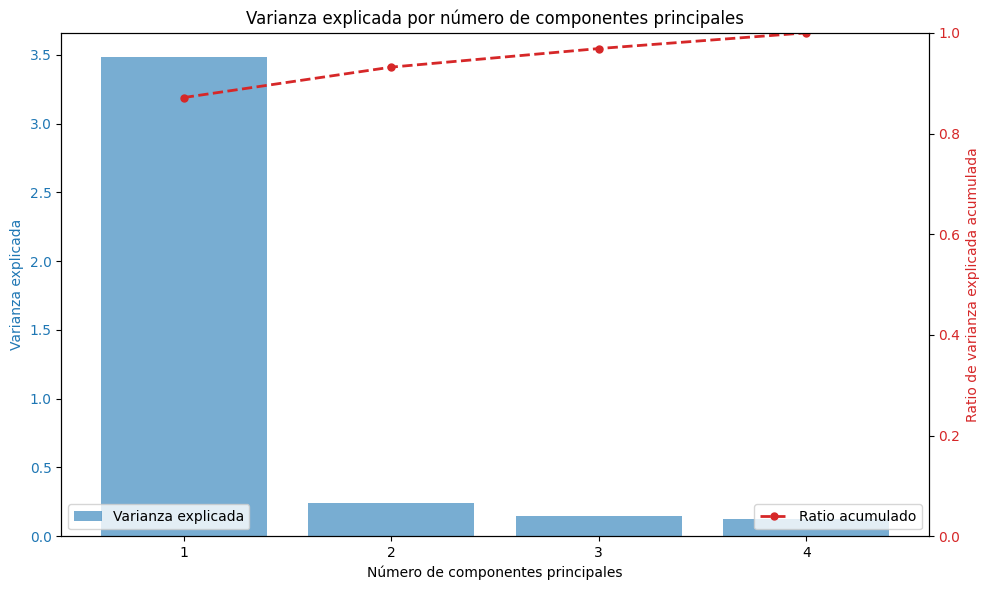

Ratio de varianza explicada:  0.8714438930460114
-------------------------------
CLUSTER 1
-------------------------------
value=229653.5240258315
np-value=0.0
Existe correlacion entre variables
(35041, 4)


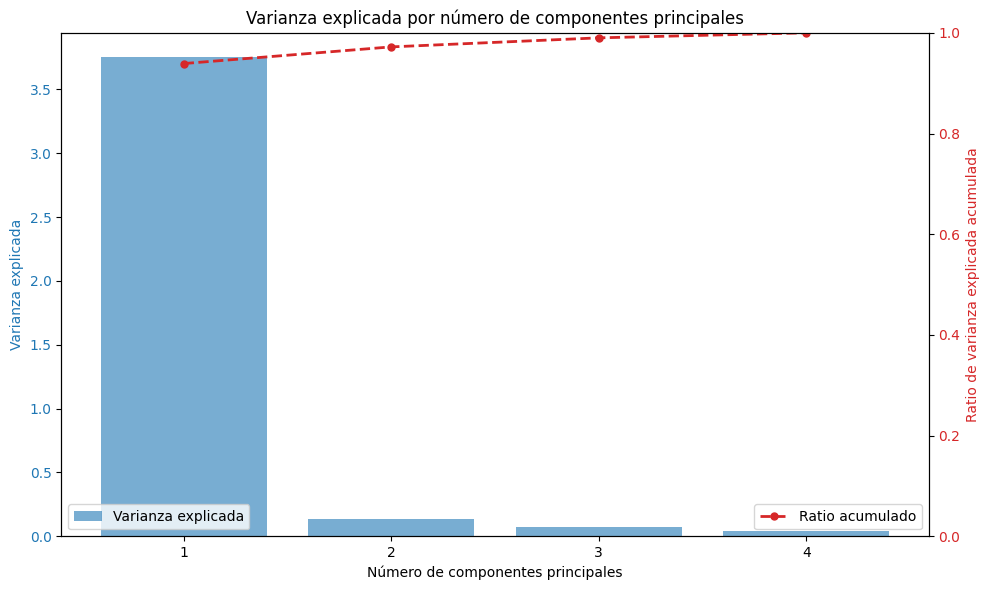

Ratio de varianza explicada:  0.9389517891063197
-------------------------------
CLUSTER 2
-------------------------------
value=20407.33573587205
np-value=0.0
Existe correlacion entre variables
(35041, 2)


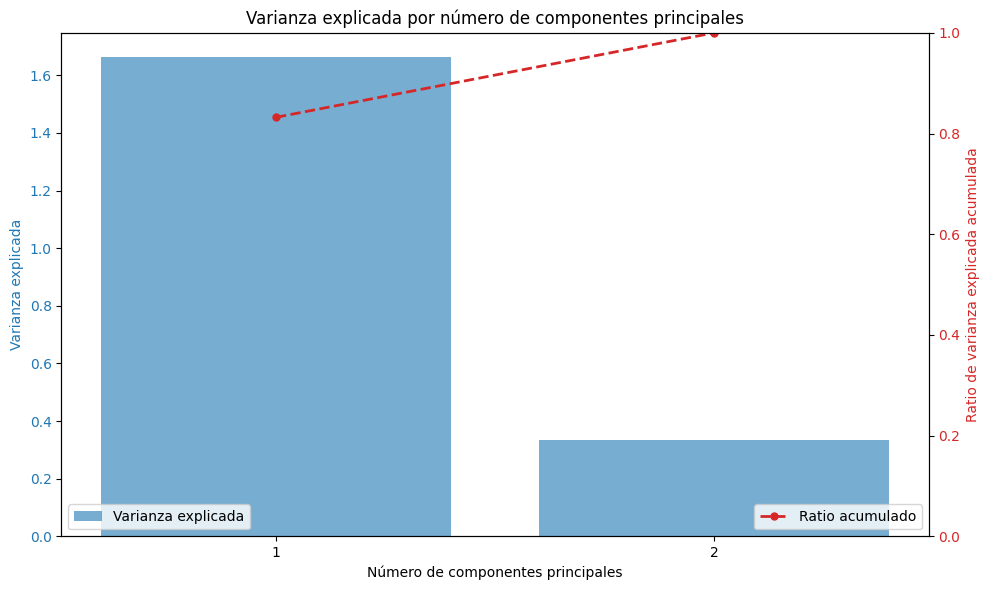

Ratio de varianza explicada:  0.8322116560978077


cluster0  cluster1  cluster2
2020-01-01 23:00:00 -2.034549 -1.884341 -1.542817
2020-01-02 00:00:00 -2.034526 -1.884006 -1.542606
2020-01-02 01:00:00 -2.034565 -1.883933 -1.542443
2020-01-02 02:00:00 -2.034718 -1.884370 -1.542347
2020-01-02 03:00:00 -2.034945 -1.885025 -1.542287

In [101]:
print("===============================")
print("PRICE")
print("===============================")
print("-------------------------------")
print("CLUSTER 0")
print("-------------------------------")
df_cluster = df_timeserie_price[price_cluster_tickers[0]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_price_cluster0.pkl')
joblib.dump(pca_model, 'model/pca_model_price_cluster0.pkl')
df_price_cluster_timeserie = pd.DataFrame(components, columns=['cluster0'],index=df_timeserie_price.index.tolist())
print("-------------------------------")
print("CLUSTER 1")
print("-------------------------------")
df_cluster = df_timeserie_price[price_cluster_tickers[1]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_price_cluster1.pkl')
joblib.dump(pca_model, 'model/pca_model_price_cluster1.pkl')
df_price_cluster_timeserie['cluster1'] = components
print("-------------------------------")
print("CLUSTER 2")
print("-------------------------------")
df_cluster = df_timeserie_price[price_cluster_tickers[2]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_price_cluster2.pkl')
joblib.dump(pca_model, 'model/pca_model_price_cluster2.pkl')
df_price_cluster_timeserie['cluster2'] = components

df_price_cluster_timeserie.head()

##### Creación de series de tiempo de volumen por cluster

VOLUME
-------------------------------
CLUSTER 0
-------------------------------
value=62302.97956584162
np-value=0.0
Existe correlacion entre variables
(35041, 4)


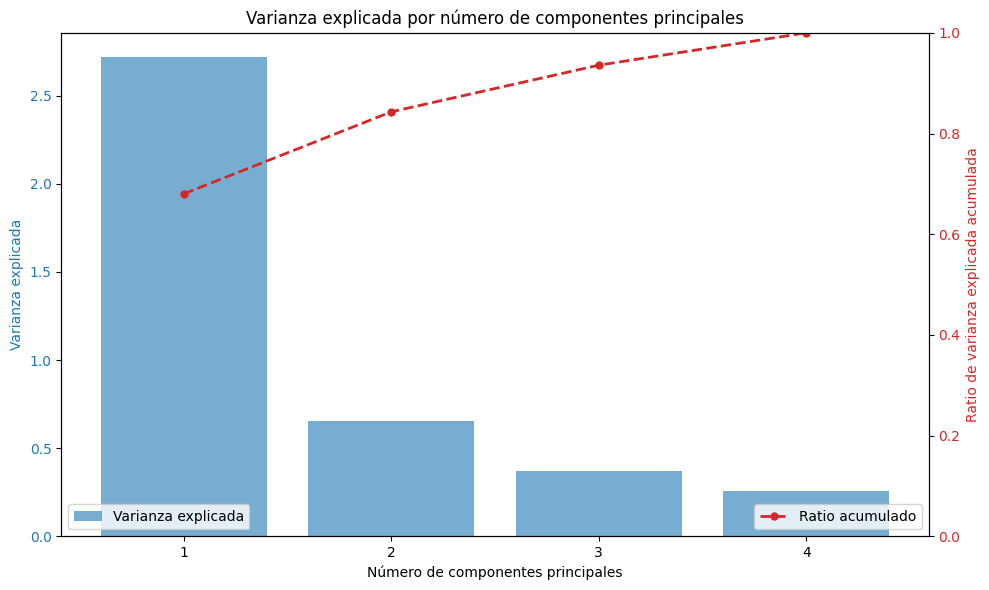

Ratio de varianza explicada:  0.6801532238093324
-------------------------------
CLUSTER 1
-------------------------------
value=28302.116072592096
np-value=0.0
Existe correlacion entre variables
(35041, 3)


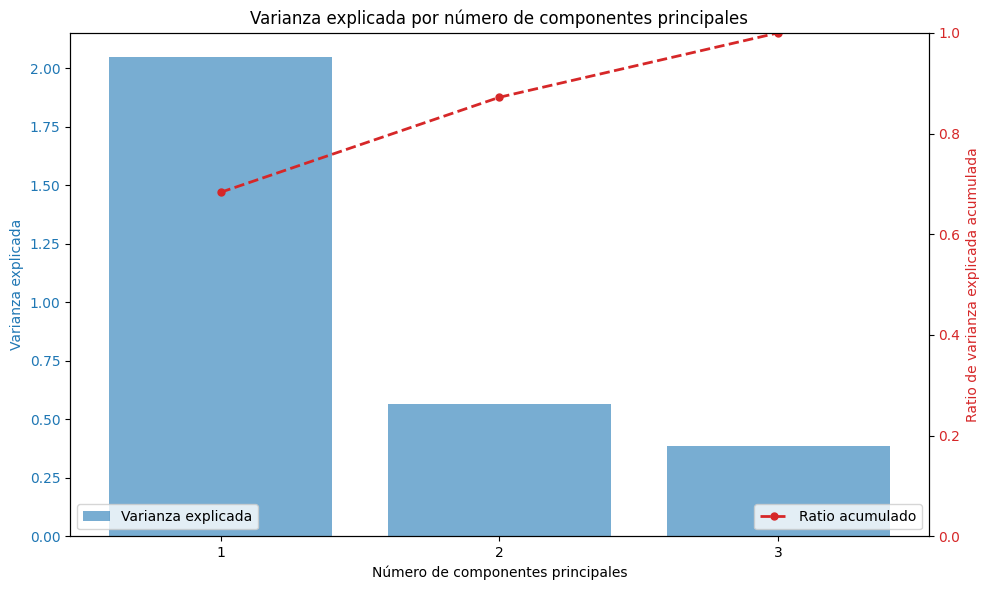

Ratio de varianza explicada:  0.6831800868998433
-------------------------------
CLUSTER 2
-------------------------------
value=1969.5052913274917
np-value=0.0
Existe correlacion entre variables
(35041, 3)


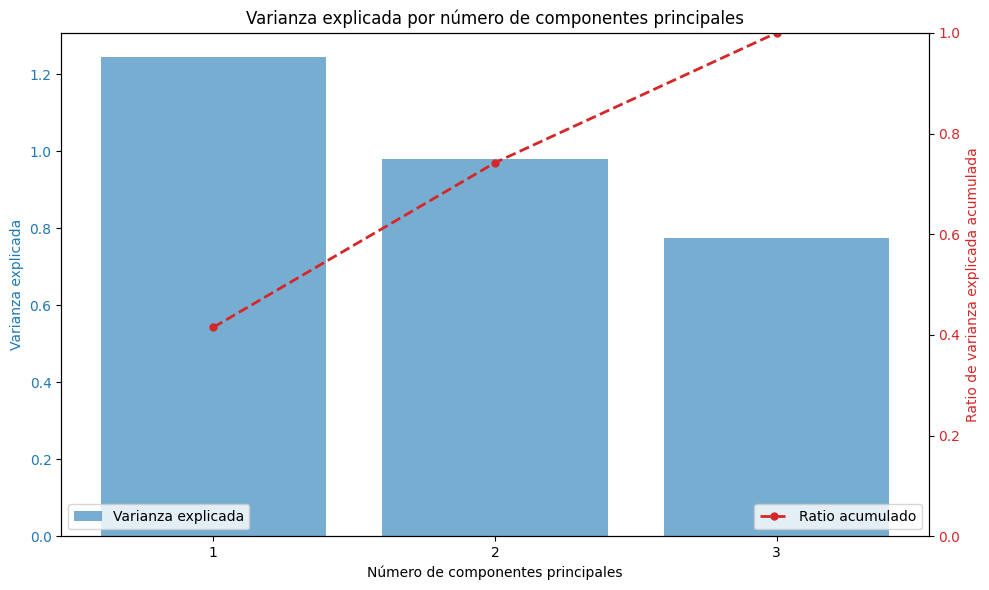

Ratio de varianza explicada:  0.4150375716416529


cluster0  cluster1  cluster2
2020-01-01 23:00:00 -2.034549 -1.884341 -1.542817
2020-01-02 00:00:00 -2.034526 -1.884006 -1.542606
2020-01-02 01:00:00 -2.034565 -1.883933 -1.542443
2020-01-02 02:00:00 -2.034718 -1.884370 -1.542347
2020-01-02 03:00:00 -2.034945 -1.885025 -1.542287

In [102]:
print("===============================")
print("VOLUME")
print("===============================")
print("-------------------------------")
print("CLUSTER 0")
print("-------------------------------")
df_cluster = df_timeserie_volume[volume_cluster_tickers[0]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_volume_cluster0.pkl')
joblib.dump(pca_model, 'model/pca_model_volume_cluster0.pkl')
df_volume_cluster_timeserie = pd.DataFrame(components, columns=['cluster0'],index=df_timeserie_volume.index.tolist())
print("-------------------------------")
print("CLUSTER 1")
print("-------------------------------")
df_cluster = df_timeserie_volume[volume_cluster_tickers[1]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_volume_cluster1.pkl')
joblib.dump(pca_model, 'model/pca_model_volume_cluster1.pkl')
df_volume_cluster_timeserie['cluster1'] = components
print("-------------------------------")
print("CLUSTER 2")
print("-------------------------------")
df_cluster = df_timeserie_volume[volume_cluster_tickers[2]]
bartlett_sphericity(df_cluster)
std_scaler, pca_model, components = pca_auto_components(df_cluster)
joblib.dump(std_scaler, 'model/pca_std_scaler_volume_cluster2.pkl')
joblib.dump(pca_model, 'model/pca_model_volume_cluster2.pkl')
df_volume_cluster_timeserie['cluster2'] = components

df_price_cluster_timeserie.head()

--------------------------
PRICE CLUSTER
--------------------------


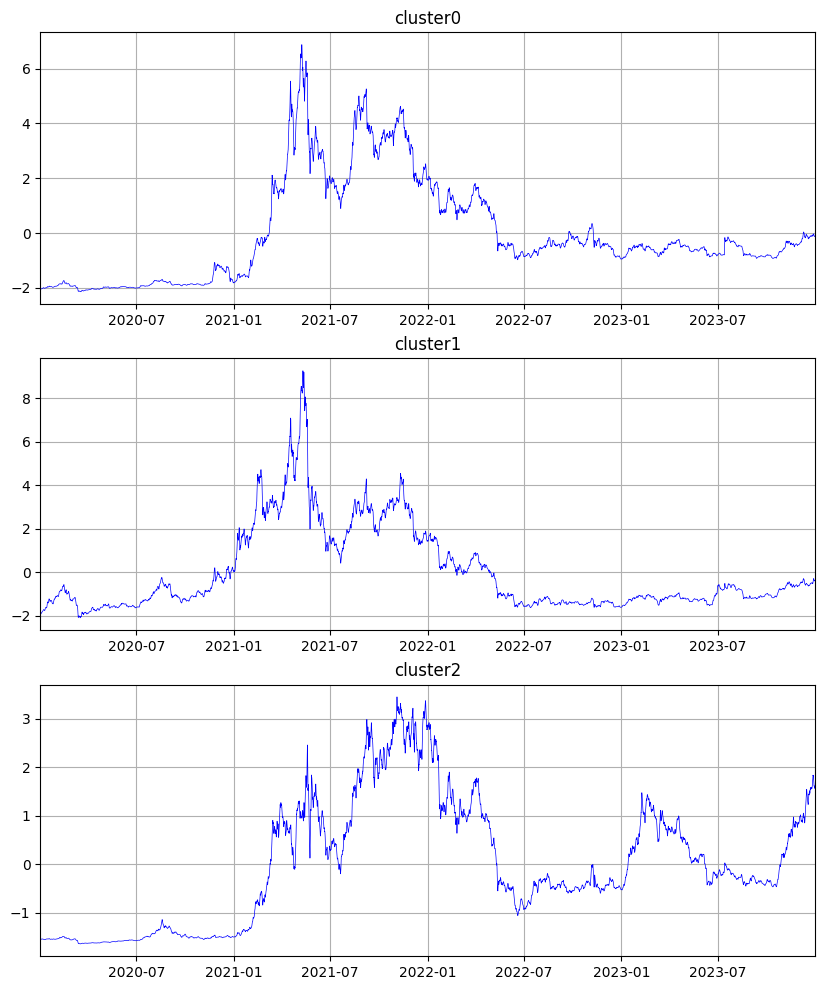

--------------------------
VOLUME CLUSTER
--------------------------


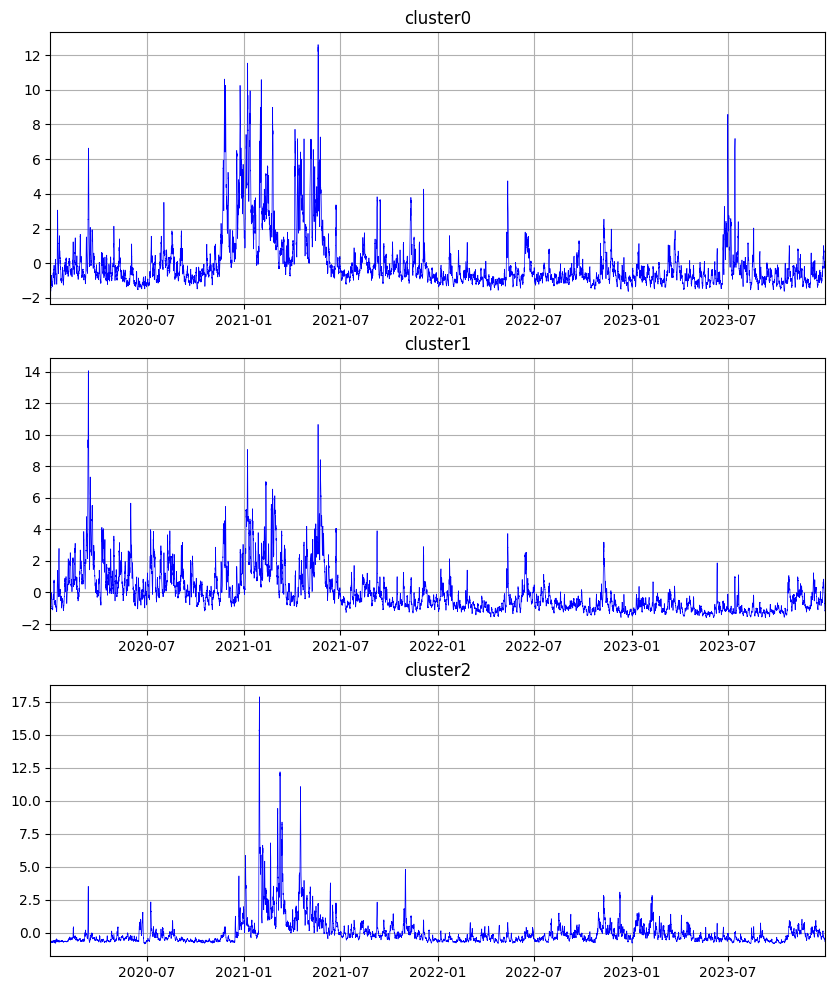

In [103]:
print("--------------------------")
print("PRICE CLUSTER")
print("--------------------------")
axe_timeserie_plot(df_price_cluster_timeserie)
print("--------------------------")
print("VOLUME CLUSTER")
print("--------------------------")
axe_timeserie_plot(df_volume_cluster_timeserie)

In [104]:
df_cluster = pd.concat(
    [df_price_cluster_timeserie, df_volume_cluster_timeserie],
    axis=1
)
df_cluster.columns = ['price_c0_pc1', 'price_c1_pc1', 'price_c3_pc1', 'volume_c0_pc1', 'volume_c2_pc1', 'volume_c3_pc1']
df_cluster.head()

price_c0_pc1  price_c1_pc1  price_c3_pc1  volume_c0_pc1  \
2020-01-01 23:00:00     -2.034549     -1.884341     -1.542817      -1.627843   
2020-01-02 00:00:00     -2.034526     -1.884006     -1.542606      -1.627288   
2020-01-02 01:00:00     -2.034565     -1.883933     -1.542443      -1.641401   
2020-01-02 02:00:00     -2.034718     -1.884370     -1.542347      -1.623988   
2020-01-02 03:00:00     -2.034945     -1.885025     -1.542287      -1.610954   

                     volume_c2_pc1  volume_c3_pc1  
2020-01-01 23:00:00      -0.493379      -0.808212  
2020-01-02 00:00:00      -0.483830      -0.808213  
2020-01-02 01:00:00      -0.470683      -0.817043  
2020-01-02 02:00:00      -0.411361      -0.805189  
2020-01-02 03:00:00      -0.372200      -0.808890

In [105]:
df_cluster.to_csv('dataset/cluster_timeseries.csv', sep=';')

In [106]:
df_model = pd.concat([df_timeserie_price, df_timeserie_volume], axis=1)
df_model.columns = [f'price_{col.lower()}' for col in df_timeserie_price.columns.tolist()] + [f'volume_{col.lower()}' for col in df_timeserie_volume.columns.tolist()]
df_model

price_xrp    price_eth     price_btc  price_xlm  \
timestamp                                                              
2020-01-01 23:00:00   0.193928   131.012292   7218.595208   0.045205   
2020-01-02 00:00:00   0.193938   131.080417   7219.280417   0.045220   
2020-01-02 01:00:00   0.193921   131.108125   7219.278854   0.045226   
2020-01-02 02:00:00   0.193848   131.067500   7217.109167   0.045219   
2020-01-02 03:00:00   0.193737   131.019688   7213.519688   0.045204   
...                        ...          ...           ...        ...   
2023-12-31 19:00:00   0.622477  2296.497083  42400.497187   0.131539   
2023-12-31 20:00:00   0.622267  2296.010417  42412.139479   0.131348   
2023-12-31 21:00:00   0.622069  2295.339896  42423.880208   0.131167   
2023-12-31 22:00:00   0.621707  2294.745104  42430.122292   0.130981   
2023-12-31 23:00:00   0.621373  2294.231771  42433.055833   0.130814   

                     price_link  price_matic  price_fet  price_ltc  \
timestamp                                                            
2020-01-01 23:00:00    1.808655     0.014633   0.038534  41.678646   
2020-01-02 00:00:00    1.810484     0.014682   0.038583  41.695000   
2020-01-02 01:00:00    1.811890     0.014734   0.038616  41.701771   
2020-01-02 02:00:00    1.812101     0.014784   0.038628  41.688958   
2020-01-02 03:00:00    1.811622     0.014830   0.038631  41.672396   
...                         ...          ...        ...        ...   
2023-12-31 19:00:00   15.232583     0.973868   0.695009  73.454583   
2023-12-31 20:00:00   15.230198     0.975270   0.694883  73.475625   
2023-12-31 21:00:00   15.228438     0.976476   0.694833  73.492812   
2023-12-31 22:00:00   15.222448     0.977248   0.694436  73.481458   
2023-12-31 23:00:00   15.213771     0.977954   0.693662  73.460729   

                     price_doge  price_chz  ...  volume_btc    volume_xlm  \
timestamp                                   ...                             
2020-01-01 23:00:00    0.002019   0.007058  ...  699.682840  3.442817e+05   
2020-01-02 00:00:00    0.002019   0.007053  ...  694.663568  3.422541e+05   
2020-01-02 01:00:00    0.002019   0.007044  ...  674.647216  3.136917e+05   
2020-01-02 02:00:00    0.002019   0.007034  ...  705.156427  3.352455e+05   
2020-01-02 03:00:00    0.002019   0.007023  ...  737.416409  3.495747e+05   
...                         ...        ...  ...         ...           ...   
2023-12-31 19:00:00    0.090243   0.088081  ...  873.149748  3.069773e+06   
2023-12-31 20:00:00    0.090220   0.088065  ...  882.230853  2.975873e+06   
2023-12-31 21:00:00    0.090196   0.088047  ...  889.265230  2.943342e+06   
2023-12-31 22:00:00    0.090163   0.087986  ...  939.648766  2.893870e+06   
2023-12-31 23:00:00    0.090131   0.087911  ...  982.746501  2.898259e+06   

                       volume_link  volume_matic    volume_fet    volume_ltc  \
timestamp                                                                      
2020-01-01 23:00:00   48281.180000  2.046159e+07  8.418431e+05   4585.203102   
2020-01-02 00:00:00   48414.406250  2.063829e+07  8.433074e+05   4573.313859   
2020-01-02 01:00:00   48155.692917  2.094476e+07  7.875475e+05   4353.185168   
2020-01-02 02:00:00   48481.170000  2.202246e+07  8.271295e+05   4384.874603   
2020-01-02 03:00:00   50282.729167  2.264715e+07  7.999109e+05   4416.693158   
...                            ...           ...           ...           ...   
2023-12-31 19:00:00  130075.558333  3.770593e+06  7.745775e+05  14909.620542   
2023-12-31 20:00:00  134595.024583  3.964752e+06  8.141566e+05  15488.220000   
2023-12-31 21:00:00  134683.815417  4.017956e+06  8.483419e+05  15773.178292   
2023-12-31 22:00:00  143966.352917  4.194502e+06  9.640370e+05  16616.492792   
2023-12-31 23:00:00  145662.094583  4.286931e+06  1.017224e+06  16794.056542   

                      volume_doge    volume_chz    volume_ada   volume_bch  
timestamp                                            

In [107]:
df_model.to_csv('dataset/modeling_data.csv', sep=';')

### MORE ANALYSIS

In [108]:
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from scipy.stats import ttest_ind
# dtaidistance import dtw

In [110]:
#Correlacion entre series de tiempo
# Cointegración
def timeseries_corr(df_timeseries:pd.DataFrame):
    for ticker1, ticker2 in combinations(df_timeseries.columns, 2):
        temp = df[[ticker1, ticker2]].dropna()
        corr = temp[ticker1].corr(temp[ticker2])
        score, p_value, _ = coint(df1['value'], df2['value'])
        if corr > 0.8:
            print(ticker1, ticker2)
            print("Correlacion: ", corr)


print(f'P-valor de cointegración: {p_value}')

# Dynamic Time Warping (DTW)
series1 = np.array(df1['value'])
series2 = np.array(df2['value'])
distance = dtw.distance(series1, series2)
print(f'Distancia DTW: {distance}')

# Prueba de Hipótesis
t_stat, p_value = ttest_ind(df1['value'], df2['value'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

NameError: name 'p_value' is not defined

1. Prueba de estacionariedad

In [ ]:
# Ho serie de tiempo no estacionaria
# Ha serie de tiempo estacionaria
for ticker in timeseries:
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(timeseries[ticker])
    print("--------------------------------------")
    print(ticker)
    print(f"ADF Statistic (original): {result[0]}")
    print(f"p-value (original): {result[1]}")
    if result[1] > 0.05:
        print("NO estacionaria")
    else:
        print("Estacionaria")

--------------------------------------
XRP
ADF Statistic (original): -2.6244813516801004
p-value (original): 0.08804228985997686
NO estacionaria
--------------------------------------
ETH
ADF Statistic (original): -1.7765804558691507
p-value (original): 0.3921492591331313
NO estacionaria
--------------------------------------
DOT
ADF Statistic (original): -1.793524245780767
p-value (original): 0.38368143244528
NO estacionaria
--------------------------------------
SHIB
ADF Statistic (original): -2.4718584932135497
p-value (original): 0.1224724469286535
NO estacionaria
--------------------------------------
BTC
ADF Statistic (original): -1.6341200109464997
p-value (original): 0.46533488005884627
NO estacionaria
--------------------------------------
XLM
ADF Statistic (original): -2.1103111122217717
p-value (original): 0.24038871619453162
NO estacionaria
--------------------------------------
LINK
ADF Statistic (original): -2.225846160124198
p-value (original): 0.19699886426416385
NO est

2. Funciones de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def autocorr_and_partialautocorr(timeseries):
    n = len(timeseries)
    lags = 200
    fig, axes = plt.subplots(n, 2, figsize=(32, 4*n))
    for i, ticker in enumerate(timeseries):
        plot_acf(timeseries[ticker], ax=axes[i, 0], lags=lags)
        plot_pacf(timeseries[ticker], ax=axes[i, 1], lags=lags)
    plt.show()

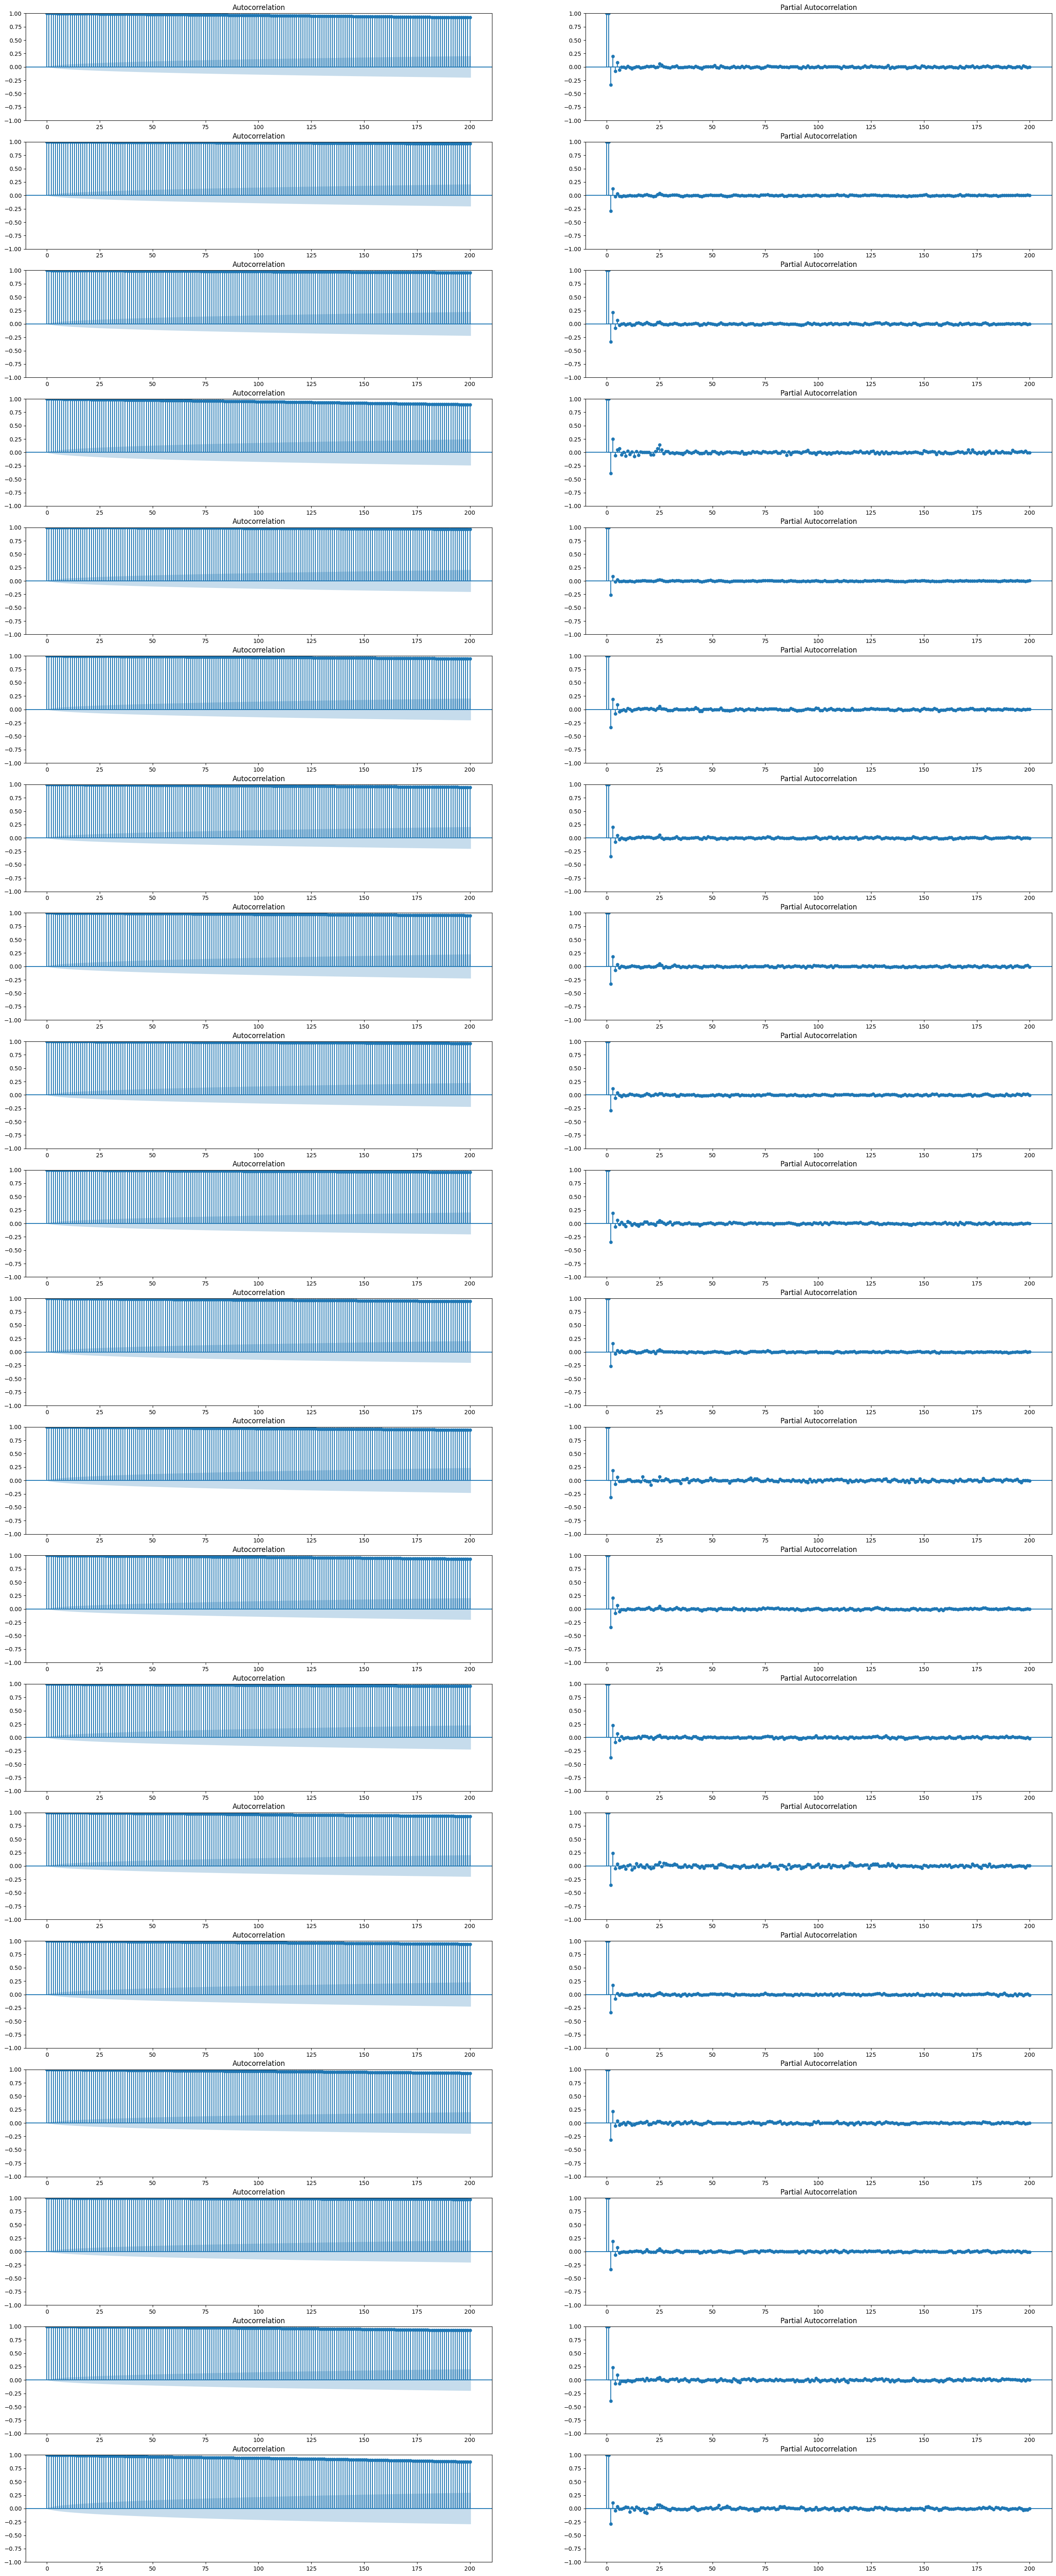

In [ ]:
autocorr_and_partialautocorr(timeseries)

Se requiere arima como modelo estadistico

La ACF ayuda a identificar cuántos retardos anteriores influyen en los valores actuales.
La PACF ayuda a identificar el número de términos autoregresivos necesarios en un modelo ARIMA eliminando la influencia de los términos intermedios.

3. Descomposición de la Serie de Tiempo

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie de tiempo
#series_log = np.log(series)
def log_timeserie(df_timeserie):
    return np.log(df_timeserie)


def diff_timeserie(df_timeserie):
    df_timeserie_diff = df_timeserie.diff().dropna()
    return df_timeserie_diff

def seasonal_decompose(df_timeserie, period=3000):
    # plt.figure(figsize=(16, 4))
    result = seasonal_decompose(
        df_timeserie, 
        model='additive', 
        period=6000) #3000
    result.plot()
    plt.show()

In [ ]:
def train_arima(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)):
    model = ARIMA(train['target'], order=order, seasonal_order=seasonal_order).fit()
    return model

# Modelado

In [ ]:
def timeserie_train_test_split(df, size):
    div = round(df.shape[0] * size)
    train = df.iloc[:div]
    test = df.iloc[div:]
    return train, test

def arima_preprocessing(df, tickers):
    models = dict()
    df[['ticker', 'open_datetime', 'PC_price']]
    for ticker in tickers:
        df_ticker = df[df['ticker'] == ticker]
        df_ticker.sort_values('open_datetime')
        df_price = df_ticker[['open_datetime', 'PC_price']]
        df_price.columns = ['date', 'target']
        df_price = df_price.set_index('date')
        df_price = df_price.asfreq('H')

### Arima

In [ ]:
train, test = timeserie_train_test_split(diff_timeserie(timeseries['XRP'], 0.8))
train_arima(train)

TypeError: diff_timeserie() takes 1 positional argument but 2 were given

In [ ]:
arima(dfs_timeseries['XRP'])

In [ ]:
model = ARIMA(series_diff['target'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Cesar\Documents\GitHub\ML-TF\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                35063
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood              339334.593
Date:                            Tue, 11 Jun 2024   AIC                        -678655.187
Time:                                    12:16:33   BIC                        -678595.935
Sample:                                01-01-2020   HQIC                       -678636.315
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1887   1.36e-21  -1.39e+20      0.000      -0.189      -0.189
ar.L2          0.1369   1.54e-21   

4. Prueba de Cointegración (Engle-Granger)


In [ ]:
from statsmodels.tsa.stattools import coint

# Crear una segunda serie de tiempo correlacionada
data2 = data + np.random.randn(100)
series2 = pd.Series(data2)

# Aplicar la prueba de cointegración
coint_t, p_value, critical_values = coint(series, series2)
print('t-statistic:', coint_t)
print('p-value:', p_value)

NameError: name 'data' is not defined

La serie de tiempo no es estacionaria

In [ ]:
df_timeserie_diff = df_timeserie.diff().dropna()
result = adfuller(df_timeserie_diff)
print(f"ADF Statistic (diff): {result[0]}")
print(f"p-value (diff): {result[1]}")

ADF Statistic (diff): -26.221193691355417
p-value (diff): 0.0


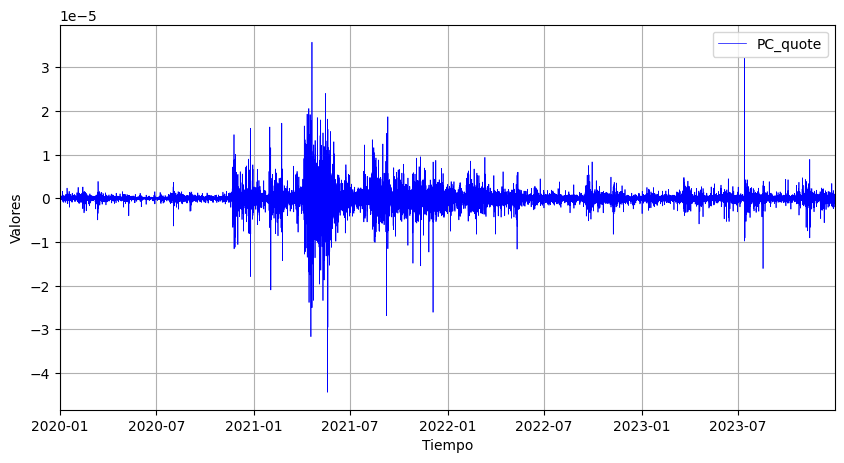

In [ ]:
timeserie_plot(df_timeserie_diff)

In [ ]:
def autotune_arima(df):
    result = adfuller(df)
    print("INITIAL ANALYSIS")
    print("----------------")
    print(f"ADF Statistic (diff): {result[0]}")
    print(f"p-value (diff): {result[1]}")
    df_timeserie = df
    if result[1] > 0.05:
        df_timeserie = df.diff().dropna()
    train, test = timeline_train_test_split(df_timeserie, 0.8)
    model = pm.auto_arima(train['target'], seasonal=False, trace=True)
    model_fit = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end)#, typ='levels')
    plt.figure(figsize=(10, 4))
    plt.plot(train, label='Entrenamiento', linewidth=0.5)
    plt.plot(test, label='Prueba', linewidth=0.5)
    plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
    plt.legend()
    plt.show()
    return model, predictions

In [ ]:
autotune_arima(df_timeserie)

INITIAL ANALYSIS
----------------
ADF Statistic (diff): -2.6244813516801004
p-value (diff): 0.08804228985997686
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-591247.758, Time=4.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-660013.658, Time=1.86 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-593452.281, Time=1.75 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-592498.384, Time=2.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-591716.660, Time=2.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-605694.532, Time=7.31 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 20.043 seconds


TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

In [ ]:
timeline_train_test_split(df_timeserie)

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

NameError: name 'train' is not defined

In [ ]:
train, test = timeserie_train_test_split(df_time_line, 0.8)
print(train.shape, test.shape)
model = pm.auto_arima(train['target'], seasonal=False, trace=True)
model_fit = model.fit()

NameError: name 'df_time_line' is not defined

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

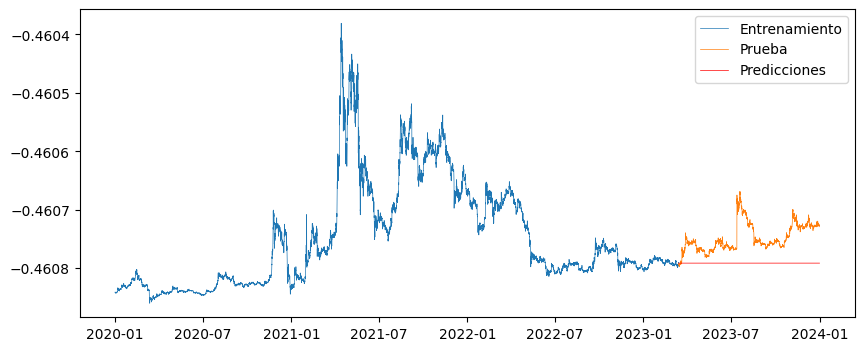

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Entrenamiento', linewidth=0.5)
plt.plot(test, label='Prueba', linewidth=0.5)
plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
model = pm.auto_arima(train['target'], seasonal=False, trace=True)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-617118.940, Time=13.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-613736.259, Time=4.91 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-614295.122, Time=6.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-621514.319, Time=5.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-636696.904, Time=2.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-652068.956, Time=9.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-620883.060, Time=69.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-624525.472, Time=63.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-618094.310, Time=84.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-614506.698, Time=50.42 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-615582.429, Time=43.63 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 354.066 seconds
                               SARIMAX Results                                
Dep. Variable:                    

In [ ]:
predictions = model.predict(n_periods=len(test))

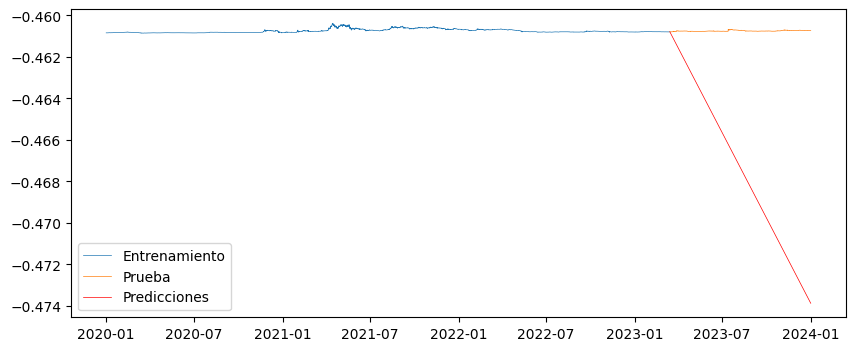

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Entrenamiento', linewidth=0.5)
plt.plot(test, label='Prueba', linewidth=0.5)
plt.plot(predictions, label='Predicciones', color='red', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model_fit.predict(start=start, end=end)#, typ='levels')

In [ ]:
type(df_price.index)
print(df_price.index.freq)

None


In [ ]:
train, test = timeserie_train_test_split(df_price, 0.8)
print(train.shape, test.shape)

(504553, 1) (126138, 1)


In [ ]:
train

target
date                         
2020-01-01 00:00:00 -0.460841
2020-01-01 01:00:00 -0.460841
2020-01-01 02:00:00 -0.460841
2020-01-01 03:00:00 -0.460841
2020-01-01 04:00:00 -0.460841
...                       ...
2023-05-23 13:00:00 -0.460454
2023-05-23 14:00:00 -0.460453
2023-05-23 15:00:00 -0.460453
2023-05-23 16:00:00 -0.460455
2023-05-23 17:00:00 -0.460455

[504553 rows x 1 columns]

In [ ]:
model = ARIMA(train['target'], order=(5, 1, 0))


c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Cesar\Documents\Develop\visual\ml-tf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

In [ ]:
import pmdarima as pm

model = pm.auto_arima(train['value'], seasonal=False, trace=True)
print(model.summary())
predictions = model.predict(n_periods=len(test))


### RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
# Función para crear secuencias y etiquetas
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50
X, y = create_sequences(timeseries['XRP'], seq_length)

X


array([[ 0.        ,  0.09993302,  0.19886554, ..., -0.99997048,
        -0.9957327 , -0.98152597],
       [ 0.09993302,  0.19886554,  0.29580708, ..., -0.9957327 ,
        -0.98152597, -0.95749254],
       [ 0.19886554,  0.29580708,  0.3897871 , ..., -0.98152597,
        -0.95749254, -0.92387301],
       ...,
       [ 0.52014028,  0.60288742,  0.67959865, ..., -0.85805249,
        -0.80243543, -0.73878464],
       [ 0.60288742,  0.67959865,  0.74950597, ..., -0.80243543,
        -0.73878464, -0.6677374 ],
       [ 0.67959865,  0.74950597,  0.81190948, ..., -0.73878464,
        -0.6677374 , -0.59000499]])

In [ ]:
len(data)

1000

In [ ]:
len(X)

950

In [ ]:
len(X[1])

50

In [ ]:
X[1]

array([ 0.09993302,  0.19886554,  0.29580708,  0.3897871 ,  0.47986471,
        0.56513807,  0.64475345,  0.71791378,  0.7838866 ,  0.84201141,
        0.89170627,  0.93247368,  0.96390547,  0.98568695,  0.99760007,
        0.99952556,  0.99144412,  0.97343668,  0.94568351,  0.90846248,
        0.86214622,  0.80719845,  0.74416927,  0.67368972,  0.59646541,
        0.51326949,  0.42493488,  0.33234597,  0.23642973,  0.13814643,
        0.03848005, -0.06157158, -0.16100677, -0.25883002, -0.35406195,
       -0.44574912, -0.53297361, -0.61486214, -0.69059488, -0.75941361,
       -0.82062935, -0.87362922, -0.91788261, -0.95294646, -0.97846973,
       -0.99419689, -0.99997048, -0.9957327 , -0.98152597, -0.95749254])

In [ ]:
12000

In [ ]:
# Redimensionar los datos para que se ajusten al modelo RNN
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')